In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.convolution import convolve, Box1DKernel
from astropy.visualization import simple_norm
from photutils.aperture import aperture_photometry
from photutils.aperture import ApertureStats
import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from photutils.aperture import CircularAnnulus, CircularAperture
from astropy.stats import SigmaClip
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
from astropy.time import Time

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
#where is TRAPPIST-1
c = SkyCoord(ra=346.62652162764437*u.degree, dec=-5.043528319429532*u.degree,
             pm_ra_cosdec=930.7875225817781*u.mas/u.yr, pm_dec=-479.0375409528857*u.mas/u.yr,frame='icrs',obstime=Time('2016-01-01 00:00:00.0'))
c.apply_space_motion(dt=7.5 * u.year)

/home/david/anaconda3/envs/stenv/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


<SkyCoord (ICRS): (ra, dec) in deg
    (346.62846831, -5.04452631)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (930.78895221, -479.0347598, 0.1141666)>

In [3]:
wfc3 = glob.glob('results/*wfc3_p*')
wfc3.sort()
wfc3

['results/epoch1_wfc3_photometry.ecsv',
 'results/epoch2_wfc3_photometry.ecsv',
 'results/epoch3_wfc3_photometry.ecsv']

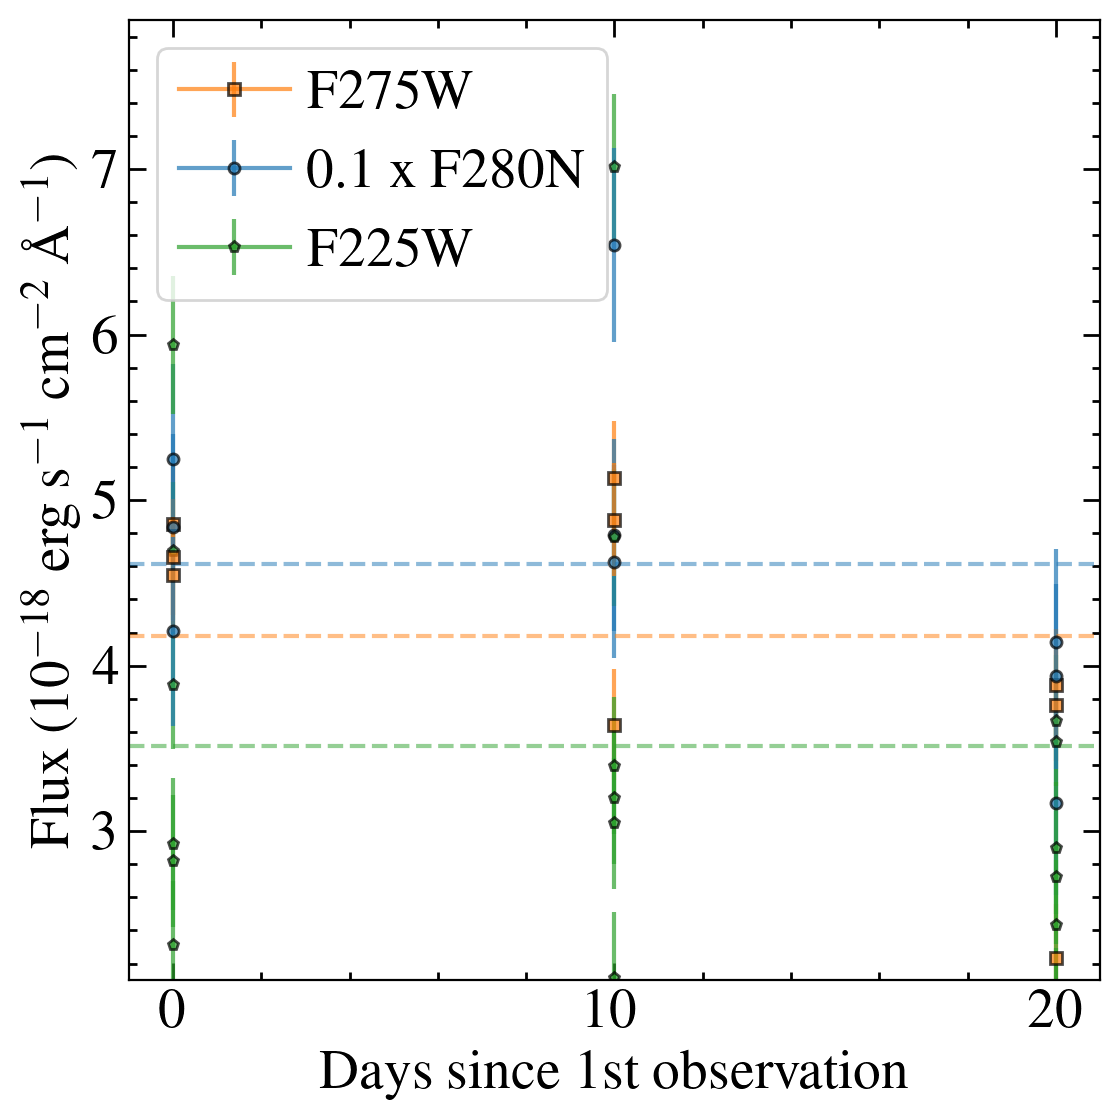

In [4]:
fig, ax = plt.subplots(figsize=(6, 6))
scale = 1e18

#2023-06-20, 2023-06-30, 2023-07-10 
days = [0, 10, 20]

f280n = []
f275w = []
f225w= []

# cols = [0, 1, 2]

for i, phot in enumerate(wfc3):
    data = Table.read(phot)
    for row in data:
        if row['FILTER'] == 'F280N':
            c = 'C0'
            m = 'o'
            f280n.append(row['FLUX'])
        elif row['FILTER'] == 'F275W':
            c = 'C1'
            m ='s'
            f275w.append(row['FLUX'])
        elif row['FILTER'] == 'F225W':
            c = 'C2'
            m ='p'
            f225w.append(row['FLUX'])
            
        if row['FILTER'] == 'F280N':
            ax.errorbar(days[i], row['FLUX']*scale/10, yerr=row['ERROR']*scale/10, label = '0.1 x {}'.format(row['FILTER']), 
                        marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)
        else:
            ax.errorbar(days[i], row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)

ax.axhline(np.mean(f280n)*scale/10, ls ='--', alpha=0.5, c='C0')
ax.axhline(np.mean(f275w)*scale, ls ='--', alpha=0.5, c='C1')
ax.axhline(np.mean(f225w)*scale, ls ='--', alpha=0.5, c='C2')
        
# ax.set_yscale('log')
ax.set_ylabel('Flux (10$^{-18}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.set_xlabel('Days since 1st observation')
ax.set_xticks(days)

# ax.set_xlim(-4, 49)
ax.set_ylim(2.1, 7.9)

    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), frameon=True, loc=2) 

fig.tight_layout()
fig.savefig('plots/wfc3_all_visits.pdf')

In [5]:
alldays = np.array([], dtype=float)

for i, phot in enumerate(wfc3):
    data = Table.read(phot)
    alldays = np.hstack((alldays, data['EXPSTART']))
    
alldays
d1 = np.min(alldays)

In [6]:
# 0.18--0.03
# 10.15-9.95
20.31-20.11

0.1999999999999993

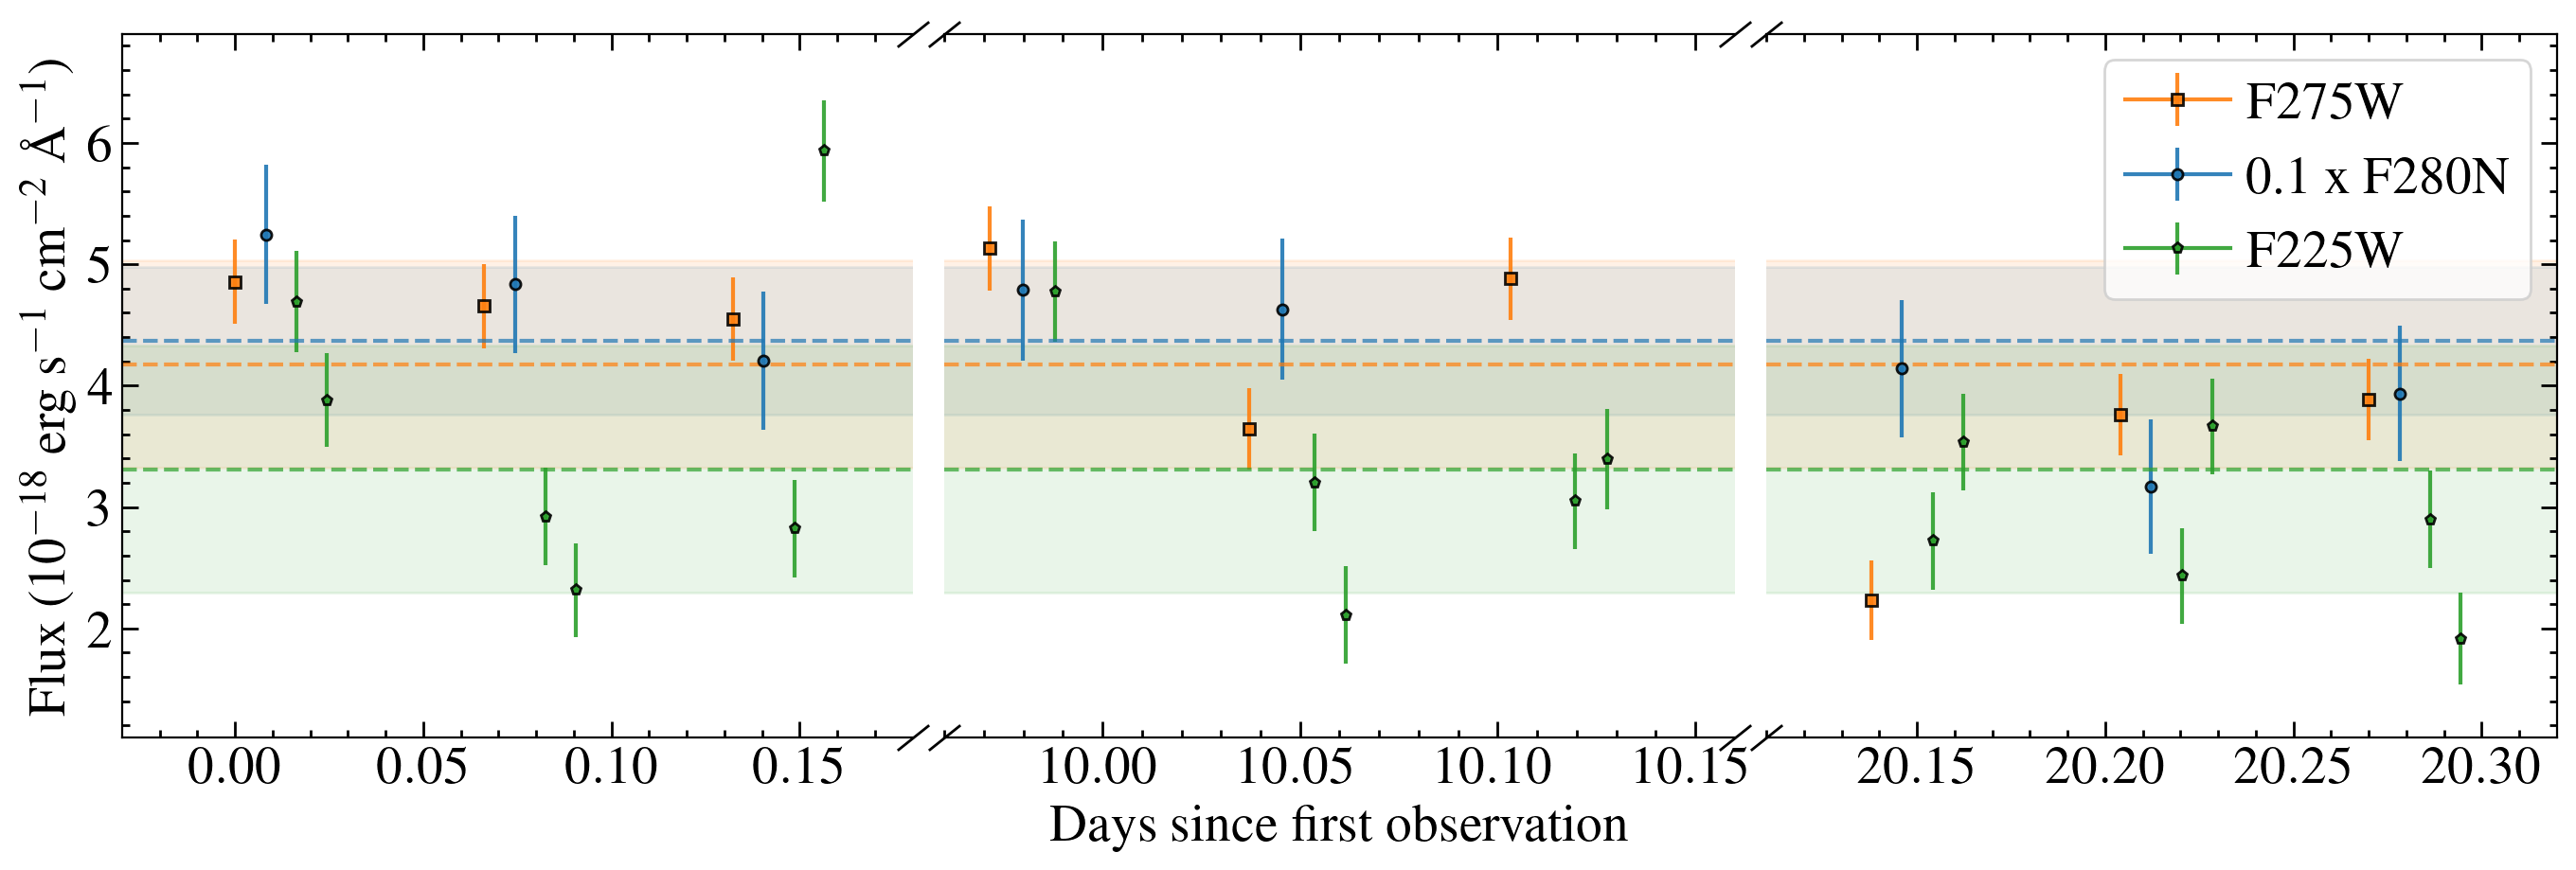

In [7]:
# fig, ax = plt.subplots(figsize=(6, 6))
# scale = 1e18

# #2023-06-20, 2023-06-30, 2023-07-10 
# days = [0, 10, 20]

f280n = []
f275w = []
f225w= []

# # cols = [0, 1, 2]



# fig.tight_layout()
# fig.savefig('plots/wfc3_all_visits.pdf')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

# plot the same data on both axes
# ax1.plot(pts)
# ax2.plot(pts)

ax1.set_xlim(-0.03, 0.18) 
ax2.set_xlim(9.96, 10.16)  
ax3.set_xlim(20.11, 20.32)  

ax1.set_ylim(1.1, 6.9)

# hide the spines between ax and ax2
# ax1.spines.bottom.set_visible(False)
ax1.spines.right.set_visible(False)
ax1.yaxis.tick_left()

ax2.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
# ax2.tick_params(labelright=False)
# ax2.yaxis.tick_left()
# ax2.yaxis.tick_right()
# ax2.tick_params(labelcolor='none', left=False, right=False, which='both')
ax2.tick_params(right = False, left=False, which='both')
# ax2.set_yticks([])

ax3.spines.left.set_visible(False)
ax3.yaxis.tick_right()
# ax2.spines.top.set_visible(False)
# ax1.xaxis.tick_top()

# ax1.tick_params(labeltop=False)  # don't put tick labels at the top
# ax2.xaxis.tick_bottom()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.

d = .8  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax2.plot([0, 1], [0, 0], transform=ax2.transAxes, **kwargs)
ax3.plot([0, 0], [1, 0], transform=ax3.transAxes, **kwargs)

# crs = ['if3i01i2q', 'if3i01i4q', 'if3i03z2q', 'if3i03zcq']
crs = ['if3i03z2q', 'if3i03zcq']


for i, phot in enumerate(wfc3):
    data = Table.read(phot)
#     data = data[mask]
    for row in data:
        if row['ROOTNAME'] not in crs:
            if row['FILTER'] == 'F280N':
                c = 'C0'
                m = 'o'
                f280n.append(row['FLUX'])
            elif row['FILTER'] == 'F275W':
                c = 'C1'
                m ='s'
                f275w.append(row['FLUX'])
            elif row['FILTER'] == 'F225W':
                c = 'C2'
                m ='p'
                f225w.append(row['FLUX'])

            if row['FILTER'] == 'F280N':
                ax1.errorbar(row['EXPSTART']-d1, row['FLUX']*scale/10, yerr=row['ERROR']*scale/10, label = '0.1 x {}'.format(row['FILTER']), 
                            marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
                ax2.errorbar(row['EXPSTART']-d1, row['FLUX']*scale/10, yerr=row['ERROR']*scale/10, label = '0.1 x {}'.format(row['FILTER']), 
                            marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
                ax3.errorbar(row['EXPSTART']-d1, row['FLUX']*scale/10, yerr=row['ERROR']*scale/10, label = '0.1 x {}'.format(row['FILTER']), 
                            marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)

            else:
                ax1.errorbar(row['EXPSTART']-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
                ax2.errorbar(row['EXPSTART']-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
                ax3.errorbar(row['EXPSTART']-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)

x = np.arange(-5, 30)
ax1.axhline(np.mean(f280n)*scale/10, ls ='--', alpha=0.7, c='C0')
ax1.axhline(np.mean(f275w)*scale, ls ='--', alpha=0.7, c='C1')
ax1.axhline(np.mean(f225w)*scale, ls ='--', alpha=0.7, c='C2')
ax1.fill_between(x, (np.mean(f280n)-np.std(f280n))*scale/10, (np.mean(f280n)+np.std(f280n))*scale/10, color='C0', alpha=0.1)
ax1.fill_between(x, (np.mean(f275w)-np.std(f275w))*scale, (np.mean(f275w)+np.std(f275w))*scale, color='C1', alpha=0.1)
ax1.fill_between(x, (np.mean(f225w)-np.std(f225w))*scale, (np.mean(f225w)+np.std(f225w))*scale, color='C2', alpha=0.1)


ax2.axhline(np.mean(f280n)*scale/10, ls ='--', alpha=0.7, c='C0')
ax2.axhline(np.mean(f275w)*scale, ls ='--', alpha=0.7, c='C1')
ax2.axhline(np.mean(f225w)*scale, ls ='--', alpha=0.7, c='C2')
ax2.fill_between(x, (np.mean(f280n)-np.std(f280n))*scale/10, (np.mean(f280n)+np.std(f280n))*scale/10, color='C0', alpha=0.1)
ax2.fill_between(x, (np.mean(f275w)-np.std(f275w))*scale, (np.mean(f275w)+np.std(f275w))*scale, color='C1', alpha=0.1)
ax2.fill_between(x, (np.mean(f225w)-np.std(f225w))*scale, (np.mean(f225w)+np.std(f225w))*scale, color='C2', alpha=0.1)

ax3.axhline(np.mean(f280n)*scale/10, ls ='--', alpha=0.7, c='C0')
ax3.axhline(np.mean(f275w)*scale, ls ='--', alpha=0.7, c='C1')
ax3.axhline(np.mean(f225w)*scale, ls ='--', alpha=0.7, c='C2')    
ax3.fill_between(x, (np.mean(f280n)-np.std(f280n))*scale/10, (np.mean(f280n)+np.std(f280n))*scale/10, color='C0', alpha=0.1)
ax3.fill_between(x, (np.mean(f275w)-np.std(f275w))*scale, (np.mean(f275w)+np.std(f275w))*scale, color='C1', alpha=0.1)
ax3.fill_between(x, (np.mean(f225w)-np.std(f225w))*scale, (np.mean(f225w)+np.std(f225w))*scale, color='C2', alpha=0.1)
# # ax.set_yscale('log')
# ax.set_ylabel('Flux (10$^{-18}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# ax.set_xlabel('Days since 1st observation')
# ax.set_xticks(days)

# # ax.set_xlim(-4, 49)
# ax.set_ylim(2.1, 7.9)

    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax3.legend(by_label.values(), by_label.keys(), frameon=True, loc=1) 

ax1.set_ylabel('Flux (10$^{-18}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax2.set_xlabel('Days since first observation')

fig.tight_layout()
fig.subplots_adjust(wspace=0.04)  # adjust space between axes



# plt.show()

# plt.savefig('plots/t1_flcs_lc.pdf')


Phase fold onto rotation period? Basically useless with that error on the rotation period, need TESS.

In [8]:
# prot = 3.3  # +/- 14,  Ducrot et al 2020 

# fig, ax = plt.subplots()

# for i, phot in enumerate(wfc3):
#     data = Table.read(phot)
#     for row in data:
#         if row['FILTER'] == 'F280N':
#             c = 'C0'
#             m = 'o'
#         elif row['FILTER'] == 'F275W':
#             c = 'C1'
#             m ='s'
#         elif row['FILTER'] == 'F225W':
#             c = 'C2'
#             m ='p'
            
#         if row['FILTER'] == 'F280N':
#             ax.errorbar(((row['EXPSTART']/prot) % 1), row['FLUX']*scale/10, yerr=row['ERROR']*scale/10, label = '0.1 x {}'.format(row['FILTER']), 
#                         marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)
#         else:
#             ax.errorbar(((row['EXPSTART']/prot) % 1), row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)



In [9]:
drcs = glob.glob('results/epoch*_wfc3_drc_photometry.ecsv')
drcs.sort()
drcs

['results/epoch1_wfc3_drc_photometry.ecsv',
 'results/epoch2_wfc3_drc_photometry.ecsv',
 'results/epoch3_wfc3_drc_photometry.ecsv']

In [10]:
wfc3

['results/epoch1_wfc3_photometry.ecsv',
 'results/epoch2_wfc3_photometry.ecsv',
 'results/epoch3_wfc3_photometry.ecsv']

results/epoch1_wfc3_photometry.ecsv


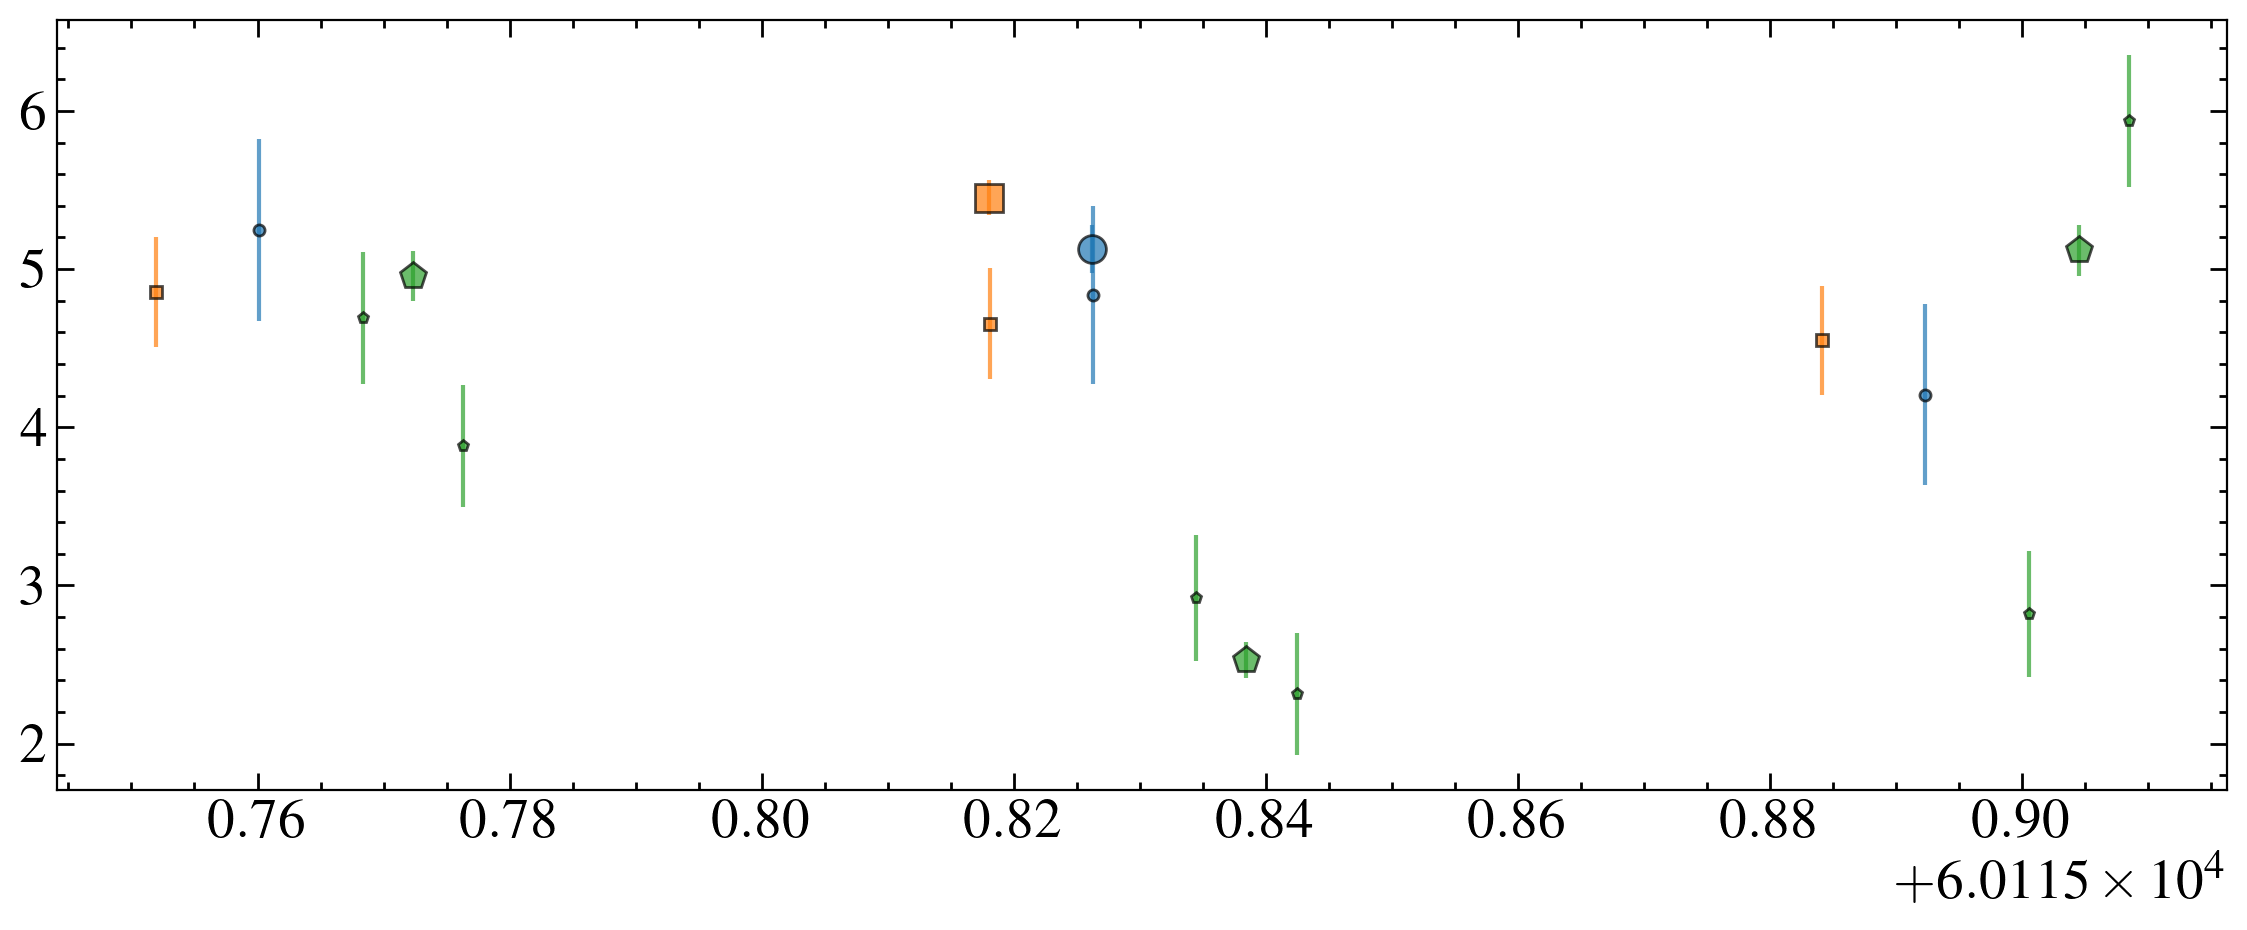

results/epoch2_wfc3_photometry.ecsv


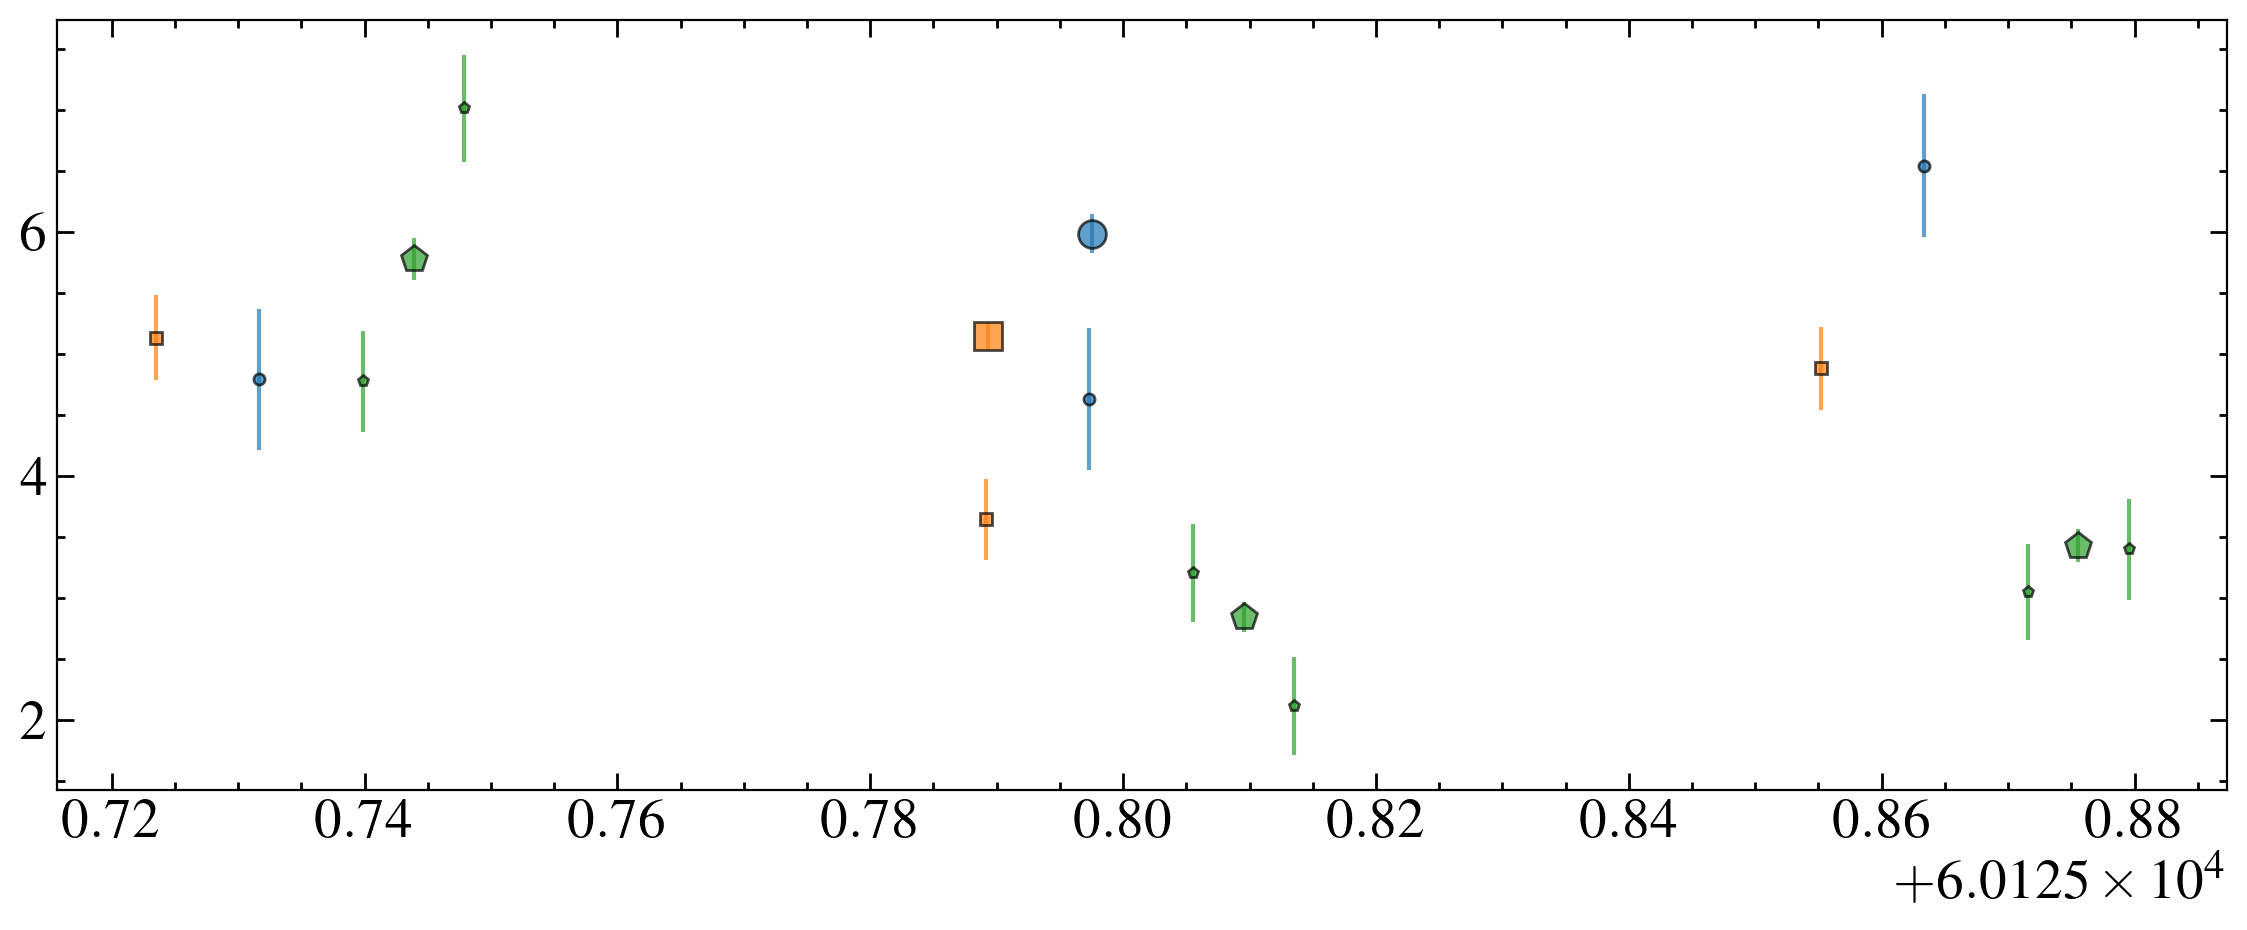

results/epoch3_wfc3_photometry.ecsv


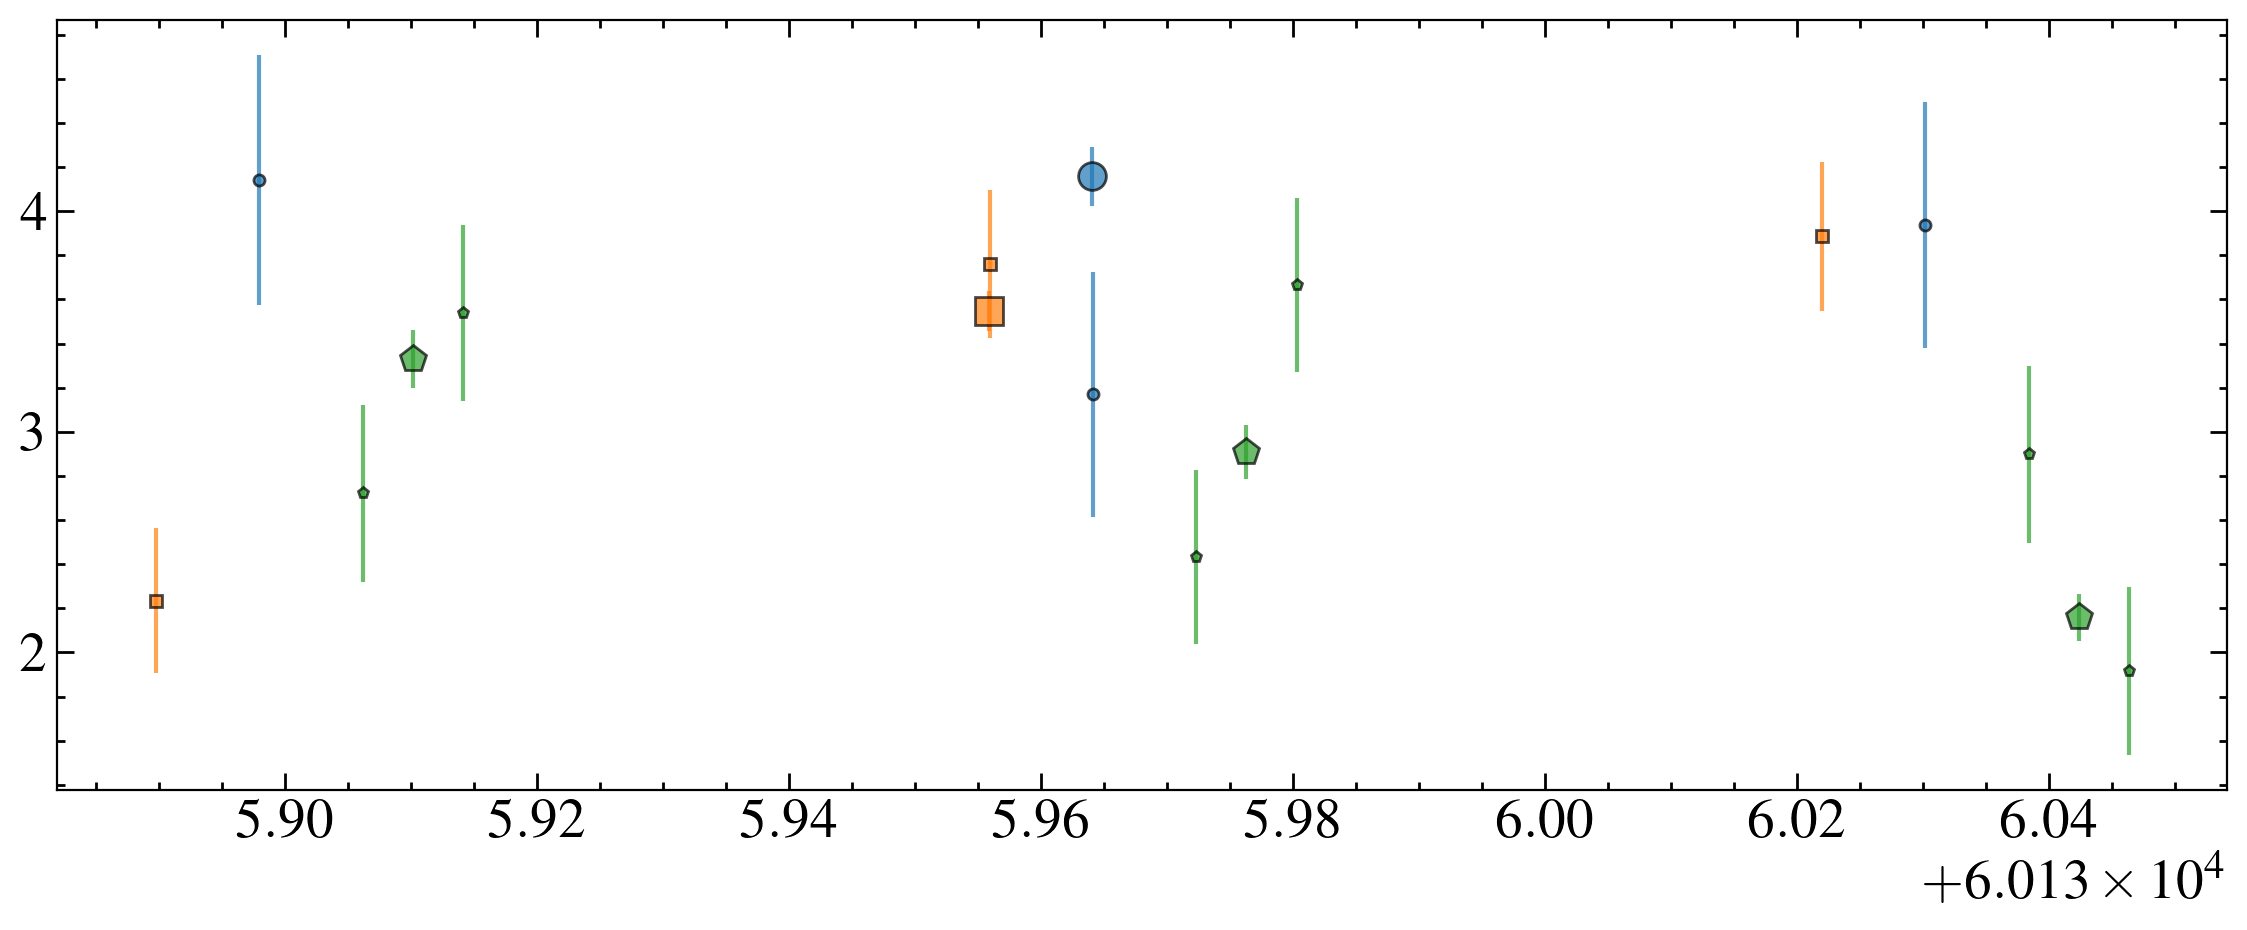

In [11]:

for i, phot in enumerate(wfc3):
    print(phot)
    fig, ax = plt.subplots()

    data = Table.read(phot)
    for row in data:
        if row['FILTER'] == 'F280N':
            c = 'C0'
            m = 'o'
        elif row['FILTER'] == 'F275W':
            c = 'C1'
            m ='s'
        elif row['FILTER'] == 'F225W':
            c = 'C2'
            m ='p'

        if row['FILTER'] == 'F280N':
            ax.errorbar((row['EXPSTART']+row['EXPEND'])/2, row['FLUX']*scale/10, yerr=row['ERROR']*scale/10, label = '0.1 x {}'.format(row['FILTER']), 
                        marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)
        else:
            ax.errorbar((row['EXPSTART']+row['EXPEND'])/2, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)

    data = Table.read(drcs[i])
    for row in data:
            if row['FILTER'] == 'F280N':
                c = 'C0'
                m = 'o'
            elif row['FILTER'] == 'F275W':
                c = 'C1'
                m ='s'
            elif row['FILTER'] == 'F225W':
                c = 'C2'
                m ='p'

            if row['FILTER'] == 'F280N':
                ax.errorbar((row['EXPSTART']+row['EXPEND'])/2, row['FLUX']*scale/10, yerr=row['ERROR']*scale/10, label = '0.1 x {}'.format(row['FILTER']), 
                            marker=m, c=c, markeredgecolor='k', markersize=10, alpha=0.7)
            else:
                ax.errorbar((row['EXPSTART']+row['EXPEND'])/2, row['FLUX']*scale, yerr=row['ERROR']*scale,
                            label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=10, alpha=0.7)
    plt.show()
            



Need to look into other late M dwarfs and see what their NUV spectra look like. LHS2686 is M5. Turns out a flat spectrum is legit?

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4] + [5]
Components: 
    [0]: <Const1D(amplitude=0.)>

    [1]: <Gaussian1D(amplitude=0., mean=2797.52959477, stddev=1.48588478)>

    [2]: <Gaussian1D(amplitude=0., mean=2804.70759477, stddev=2.44957783)>

    [3]: <BlackBody(temperature=7933.92528247, scale=0.)>

    [4]: <Gaussian1D(amplitude=0., mean=2381.24185023, stddev=27.85042034)>

    [5]: <Gaussian1D(amplitude=0., mean=2617.75646478, stddev=16.50889674)>
Parameters:
    amplitude_0     amplitude_1      ...       mean_5            stddev_5     
    ----------- -------------------- ... ------------------ ------------------
            0.0 4.94193998810127e-15 ... 2617.7564647770732 16.508896744462866


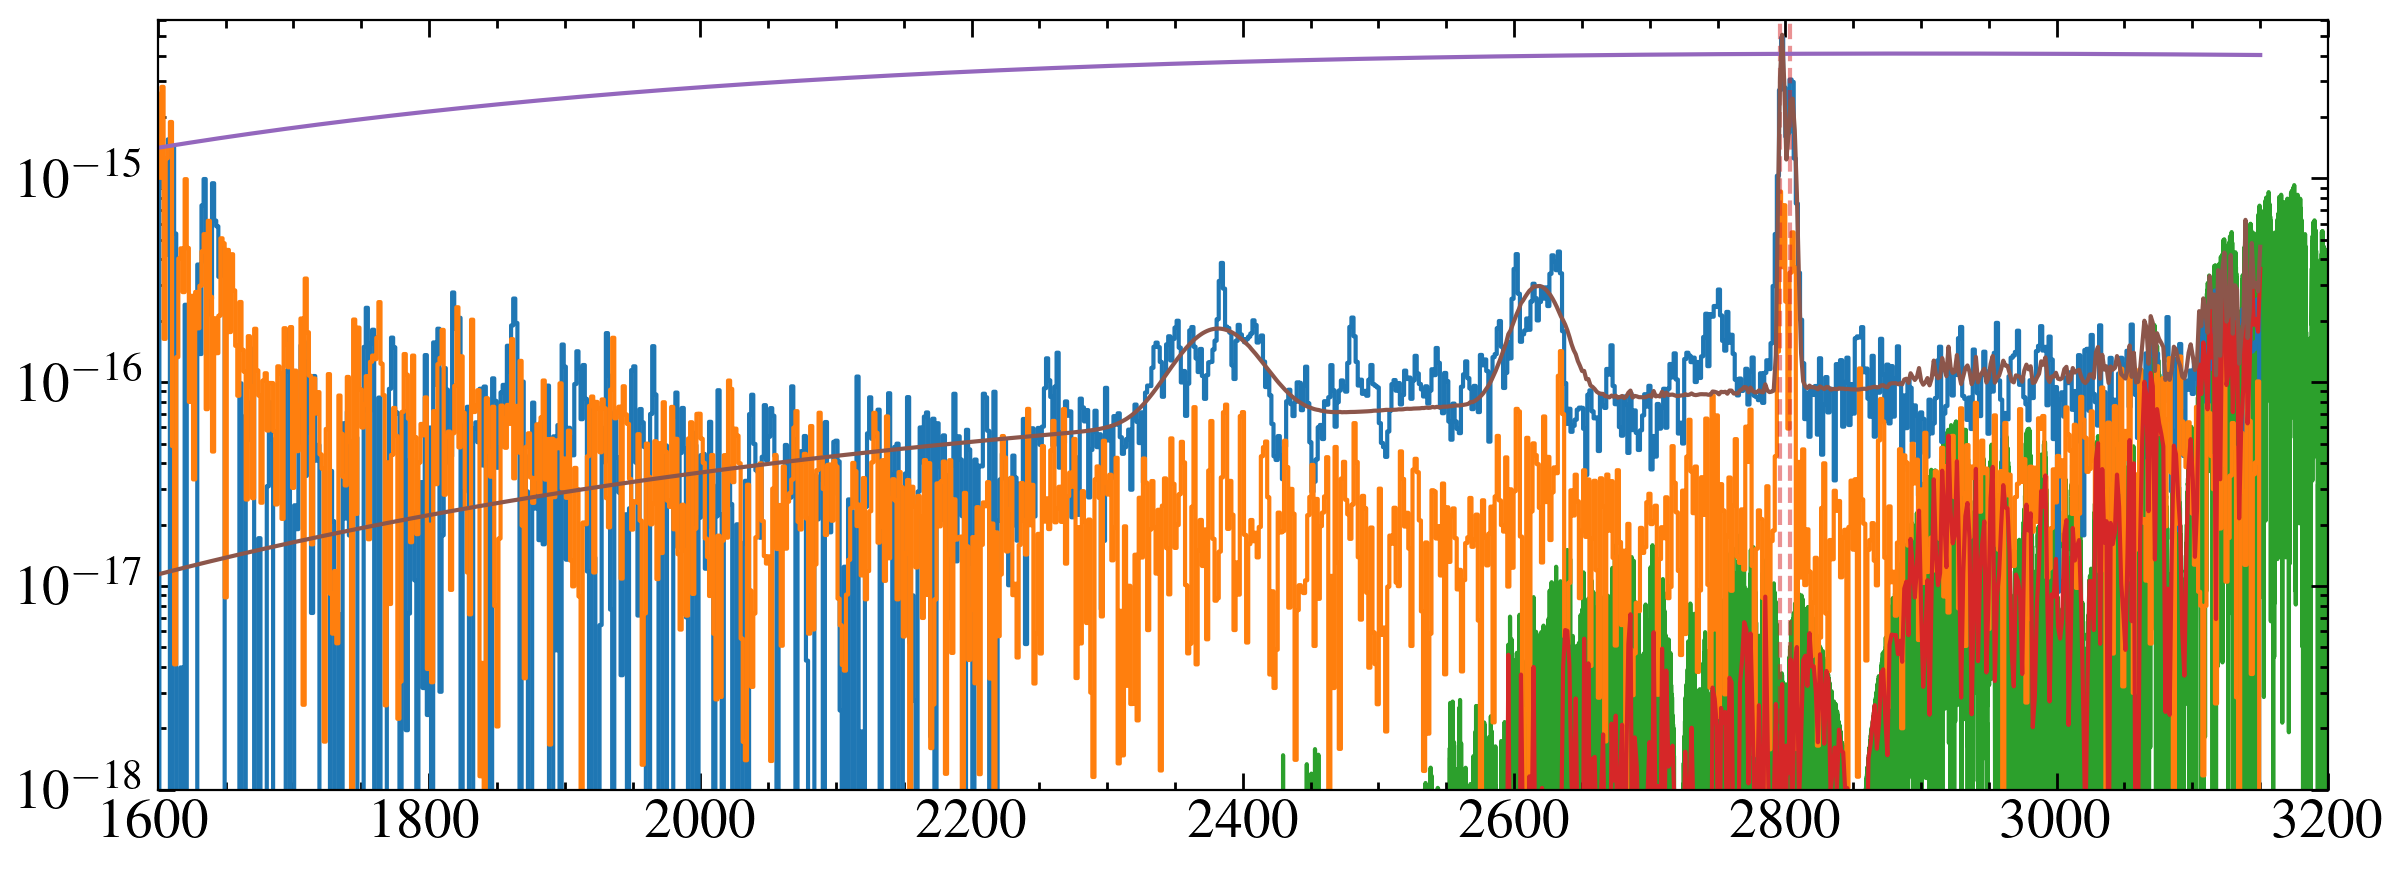

In [12]:
fig, ax = plt.subplots()

m6path ='/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/LHS-2686/'
phx = 'hlsp_muscles_model_phx_lhs-2686_na_v24_component-spec.fits'
nuv = 'hlsp_muscles_hst_stis_lhs-2686_g230l_v24_component-spec.fits'

ndata = fits.getdata(m6path+nuv,1)
wn, fn, en = ndata['WAVELENGTH'], ndata['FLUX'], ndata['ERROR']
ax.step(wn, fn, where='mid')
ax.step(wn, en, where='mid')

pdata = fits.getdata(m6path+phx,1)
norm = fits.getheader(m6path+phx)['NORMFAC']
wp, fp = pdata['WAVELENGTH'], pdata['FLUX']*norm
ax.plot(wp, fp, zorder=-1)

pfi = interp1d(wp, fp, fill_value='extrapolate')(wn)
ax.plot(wn, pfi)

fitter = fitting.LevMarLSQFitter()

mg2 = [2796.352, 2803.53]
os = [6.08e-01, 3.03e-01]

lines = np.copy(mg2)

mod = models.Const1D(0, fixed=dict(amplitude=True))
for line in lines:
    line_guess = (-50*u.km/u.s).to(u.AA, equivalencies = u.doppler_optical(line*u.AA)).value
    mod = mod+  models.Gaussian1D(amplitude=np.max(fn)/2, mean = line_guess, stddev=0.5)
    # mod = mod + functional_models.Voigt1D(x_0=line_guess, amplitude_L=np.max(fn), fwhm_G=1, fwhm_L=1, bounds=dict(amplitude_L=[0, 1]))
    # plt.axvline(line, ls='--', c='C2', alpha =0.5)
    plt.axvline(line_guess, ls='--', c='C3', alpha =0.5)

def tiedfunc0(mod):
    mean = mod.mean_1.value+np.diff(lines)
    return mean

def tiedfunc1(mod):
    x_0 = mod.x_0_1.value+np.diff(lines)
    # fwhm_G = mod.fwhm_G_1.value
    return x_0

def tiedfwhmg(mod):
    fwhm_G = mod.fwhm_G_1.value
    return fwhm_G

def tiedfwhml(mod):
    fwhm_L = mod.fwhm_L_1.value
    return fwhm_L

def tiedamp(mod):
    amplitude = mod.amplitude_1.value/(os[0]/os[1])
    return amplitude

mod.mean_2.tied=tiedfunc0
mod.amplitude_2.tied = tiedamp

#blackbody

bb_init = models.BlackBody(temperature=10000*u.K, scale=1e-22*u.erg/u.s/u.cm**2/u.AA/u.sr, bounds = dict(temperature=(2000, 20000)))

ax.plot(wn, bb_init(wn))

mod = mod+bb_init

#fe regions
femod =  models.Gaussian1D(amplitude=0.5e-15, mean = 2360, stddev=50) + models.Gaussian1D(amplitude=0.5e-15, mean = 2600, stddev=10)
# femod =  models.Box1D(amplitude=1e-16, x_0 = 2360, width=50) + models.Box1D(amplitude=1e-16, x_0 = 2600, width=70)

mod = mod+femod


mask = (wn > 2000) & (wn < 3100) #& (fn > 0)

gg_fit = fitter(mod, wn[mask], fn[mask]-pfi[mask], maxiter=100000)#, weights = 1/en[mask])

print(gg_fit)




# if type(fitter.fit_info['param_cov']) == np.ndarray:
# #     print('hooray!')
#     fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
#     print(fit_e)
    
ax.plot(wn, gg_fit(wn)+pfi)
# gg_fit




ax.set_yscale('log')

ax.set_xlim(1600, 3200)
ax.set_ylim(1e-18, 6e-15)

final_mod = gg_fit[3](wn) + gg_fit[4](wn)+gg_fit[5](wn)

savdat = Table([wn, final_mod], names=['WAVELENGTH', 'FLUX'])
savdat.write('model_spectra/lhs2686_nuv_model.ecsv', format='ascii.ecsv', overwrite=True)

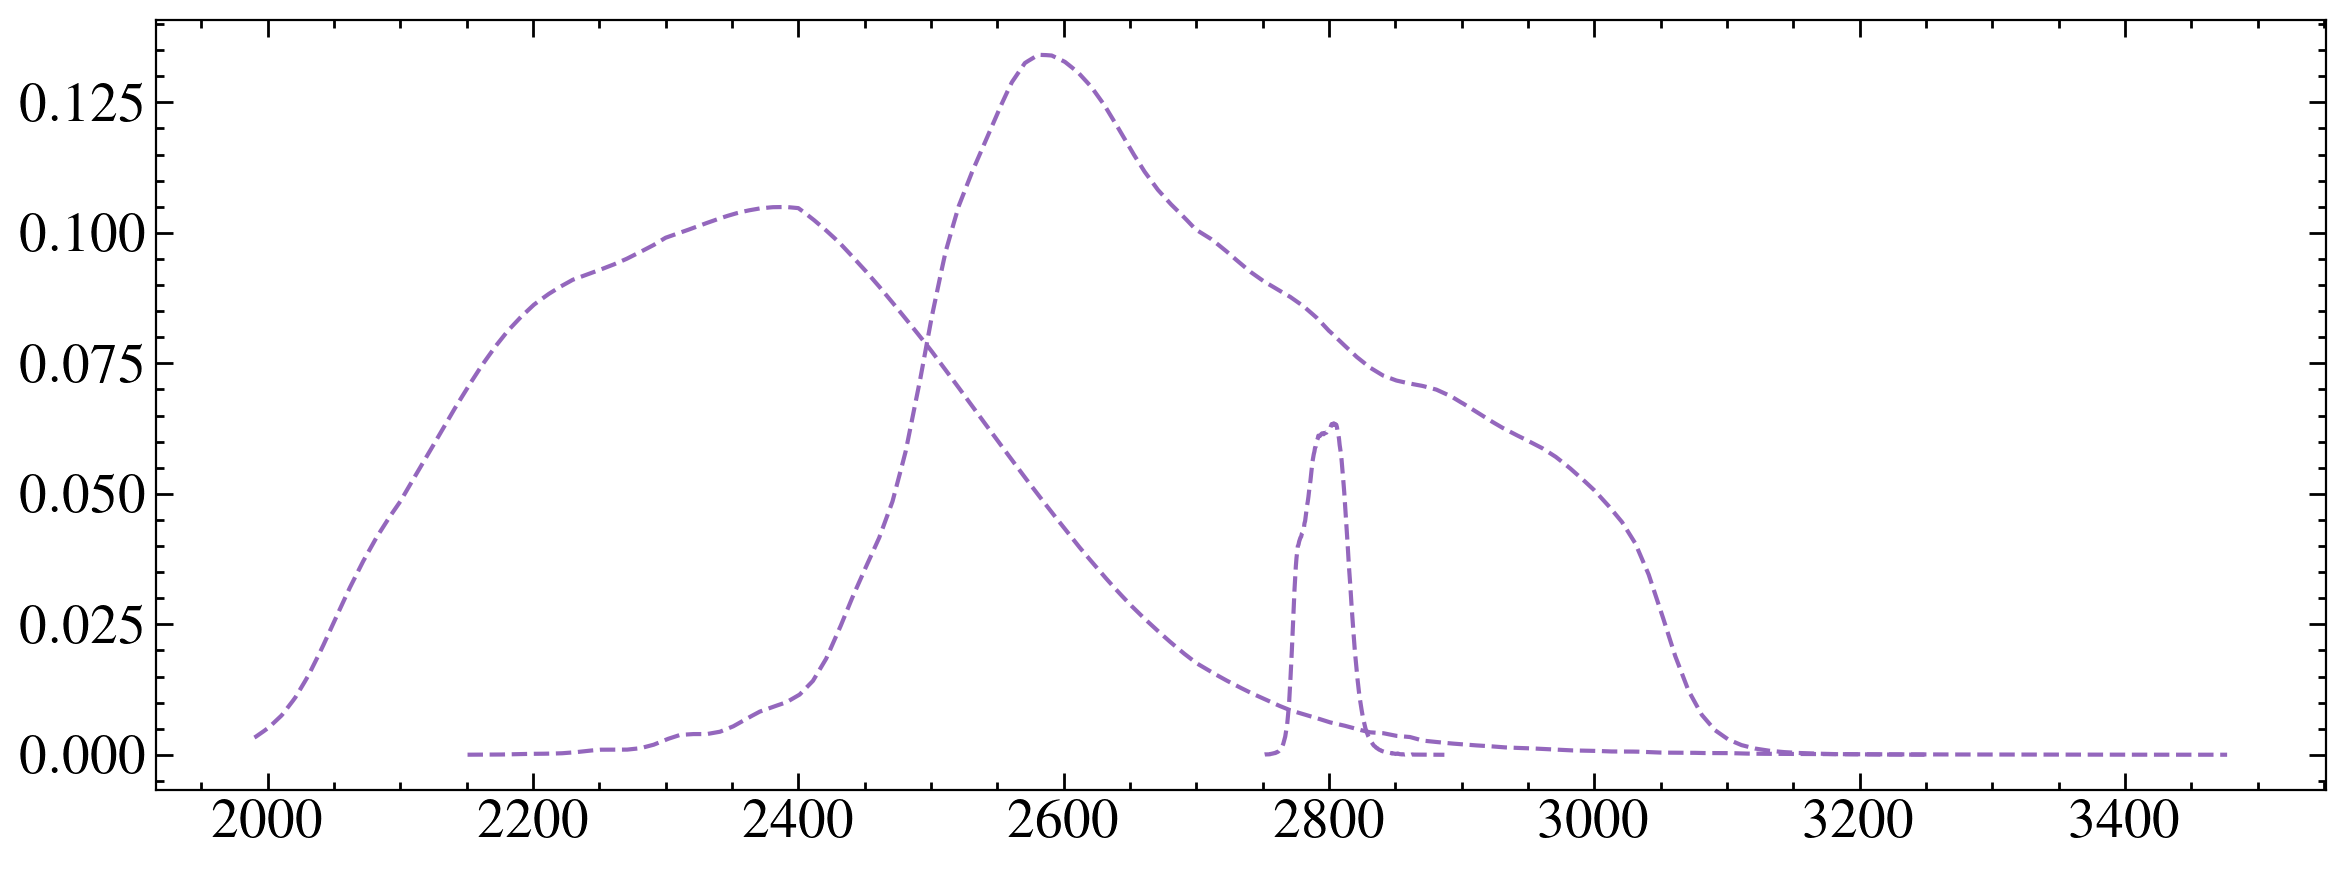

In [13]:
bands= glob.glob('filters/*UVIS*')
for band in bands:
    bpw, bpf = np.loadtxt(band, unpack=True)
    plt.plot(bpw, bpf, ls ='--', c='C4', label = 'Transmission Profiles')

Check bakground fluxes

In [14]:
data.dtype.names

('EXPSTART',
 'EXPEND',
 'EXPTIME',
 'FILTER',
 'FLUX',
 'ERROR',
 'ROOTNAME',
 'COUNTS',
 'COUNTS_ERROR',
 'BACKGROUND')

results/epoch1_wfc3_photometry.ecsv
results/epoch2_wfc3_photometry.ecsv
results/epoch3_wfc3_photometry.ecsv


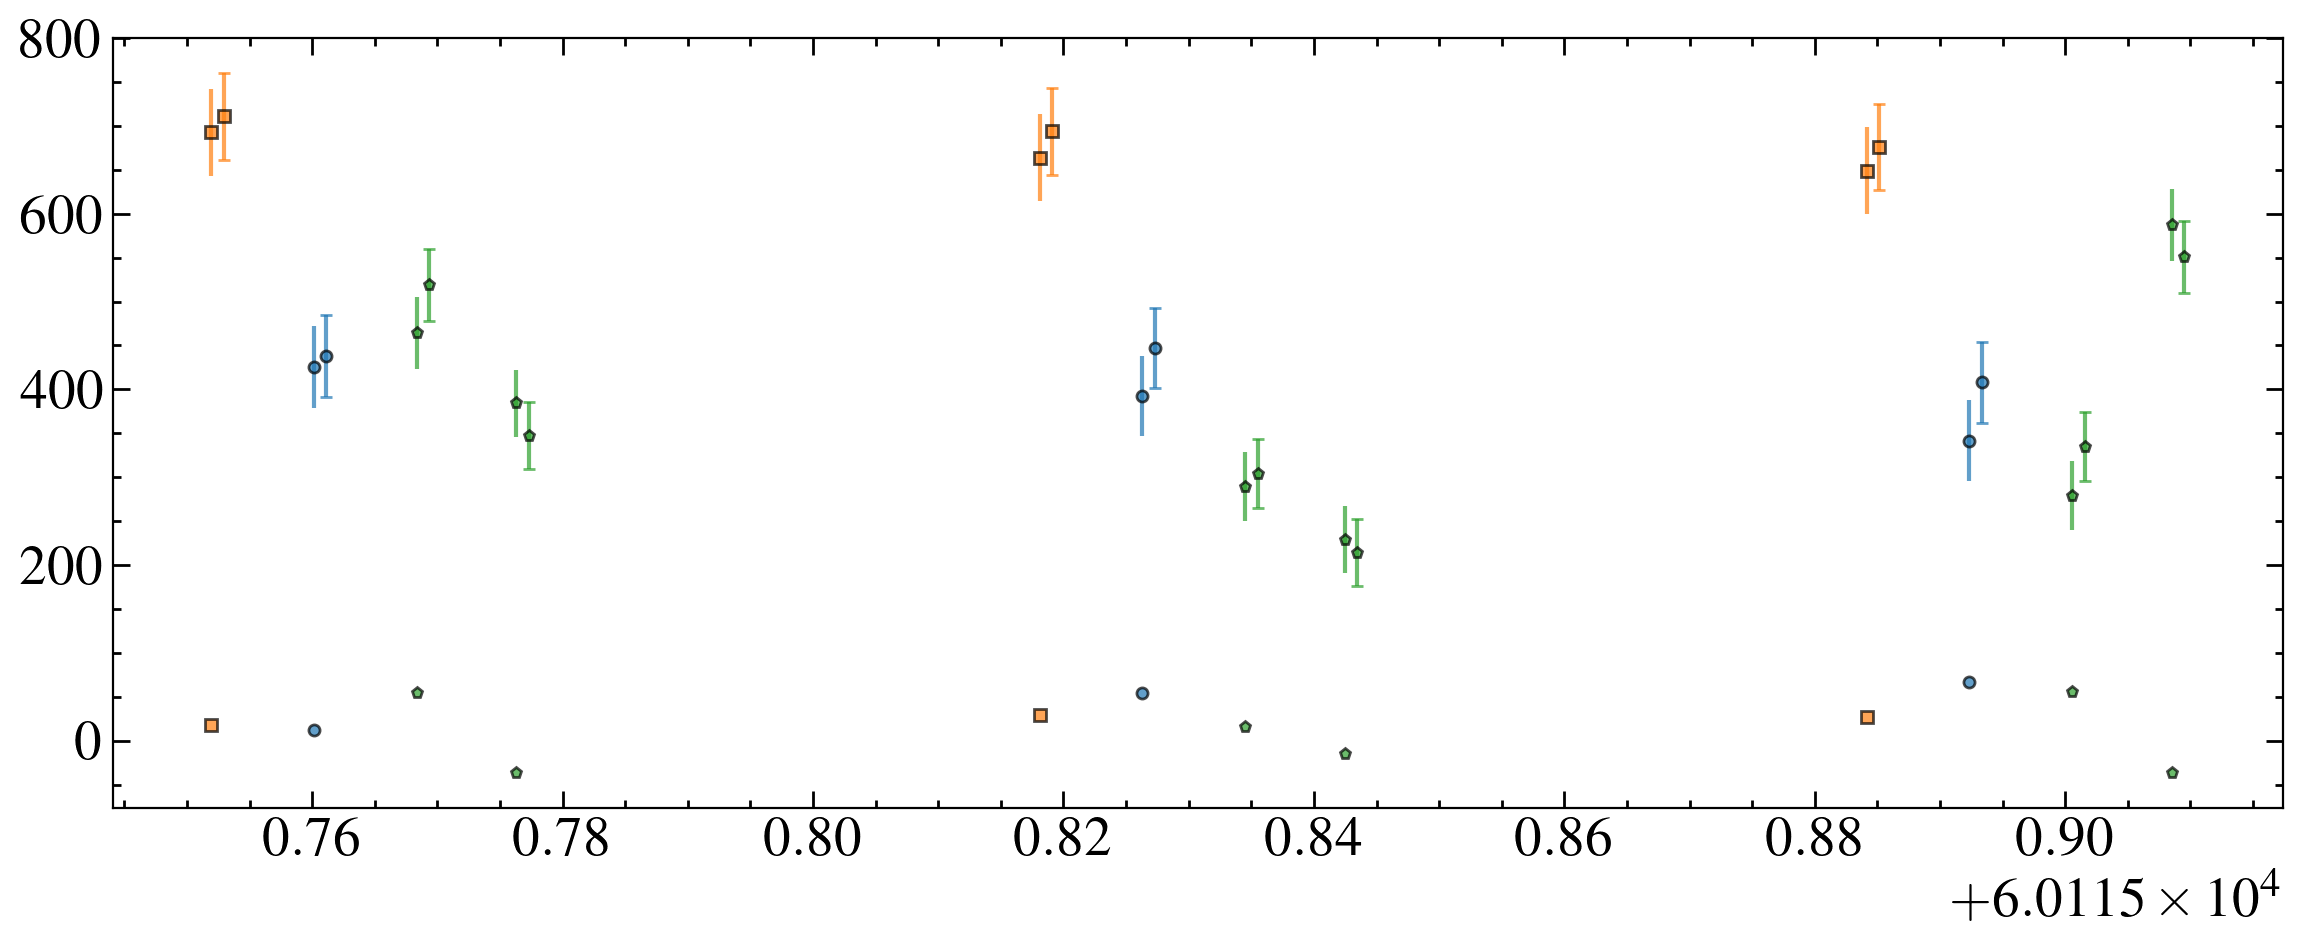

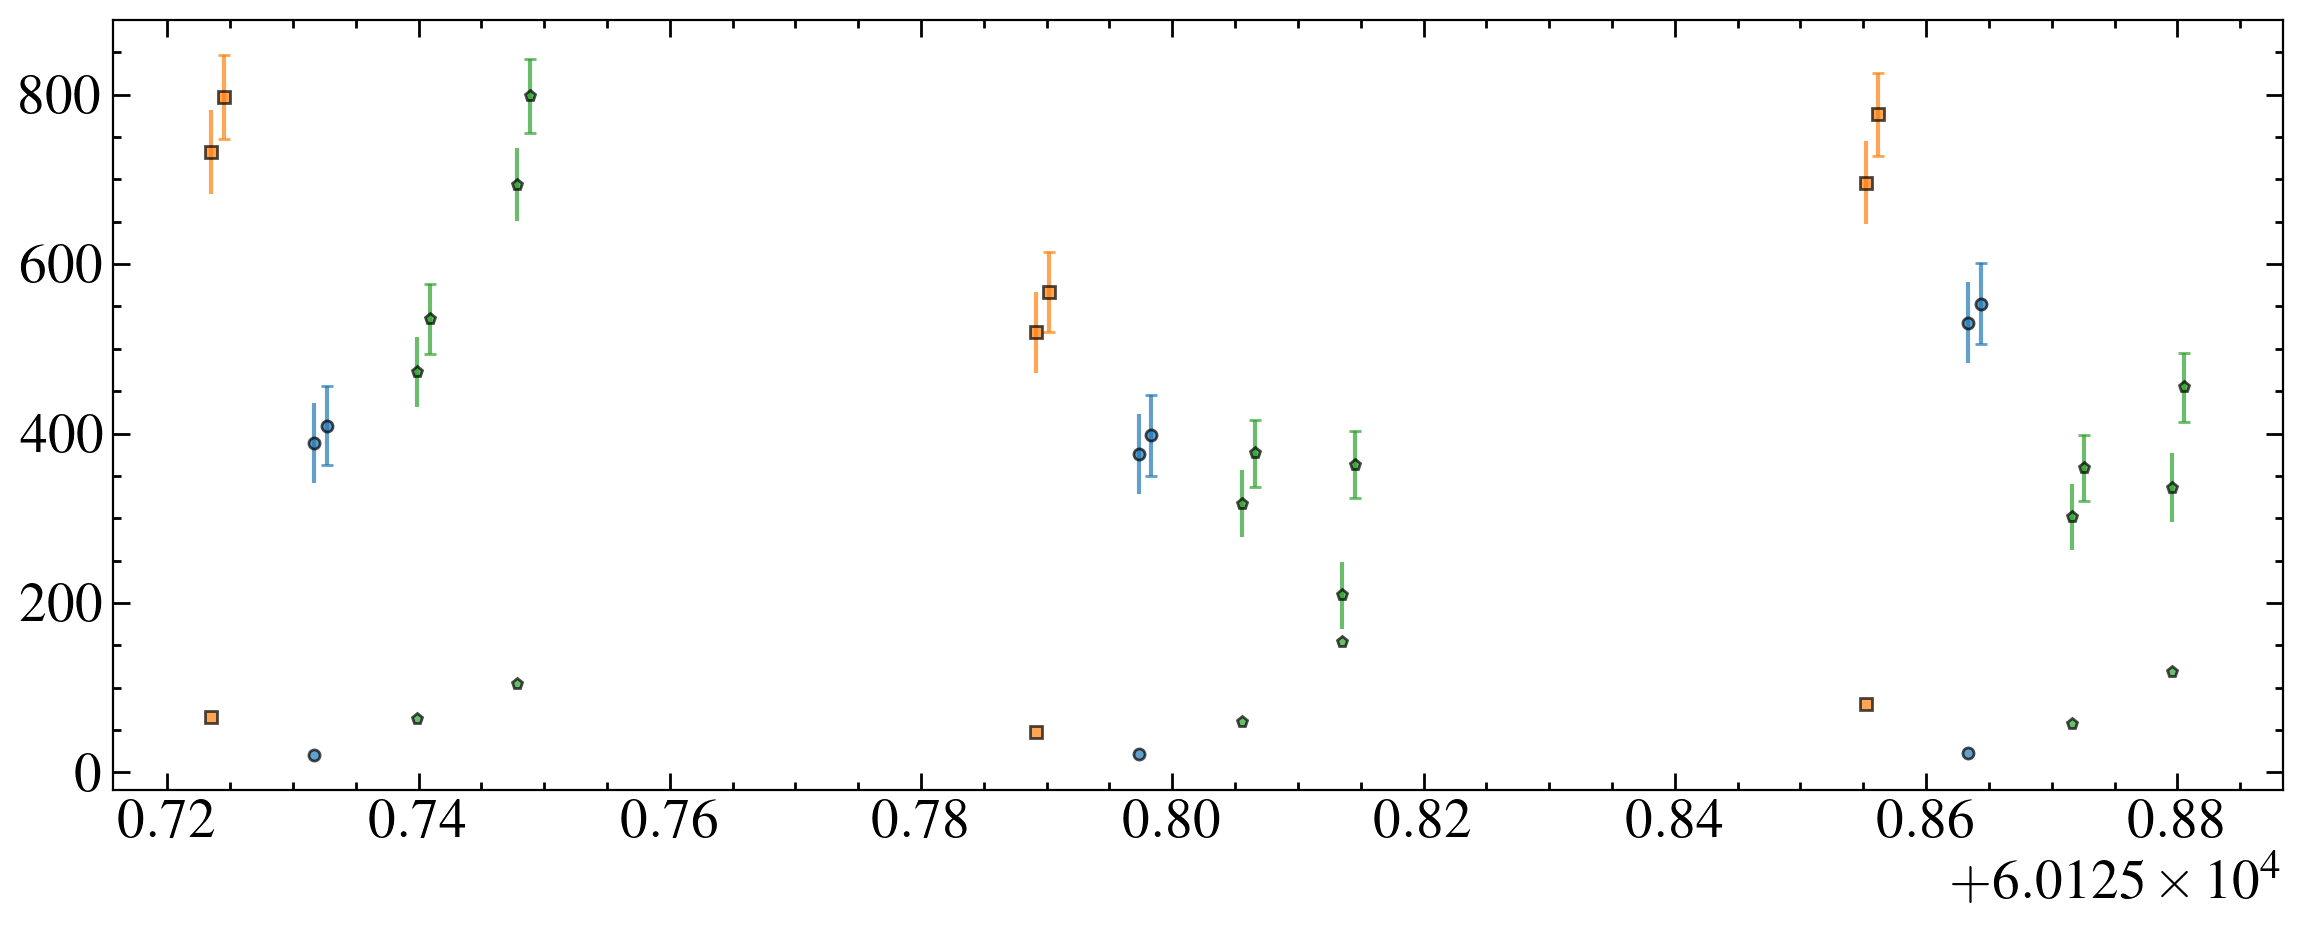

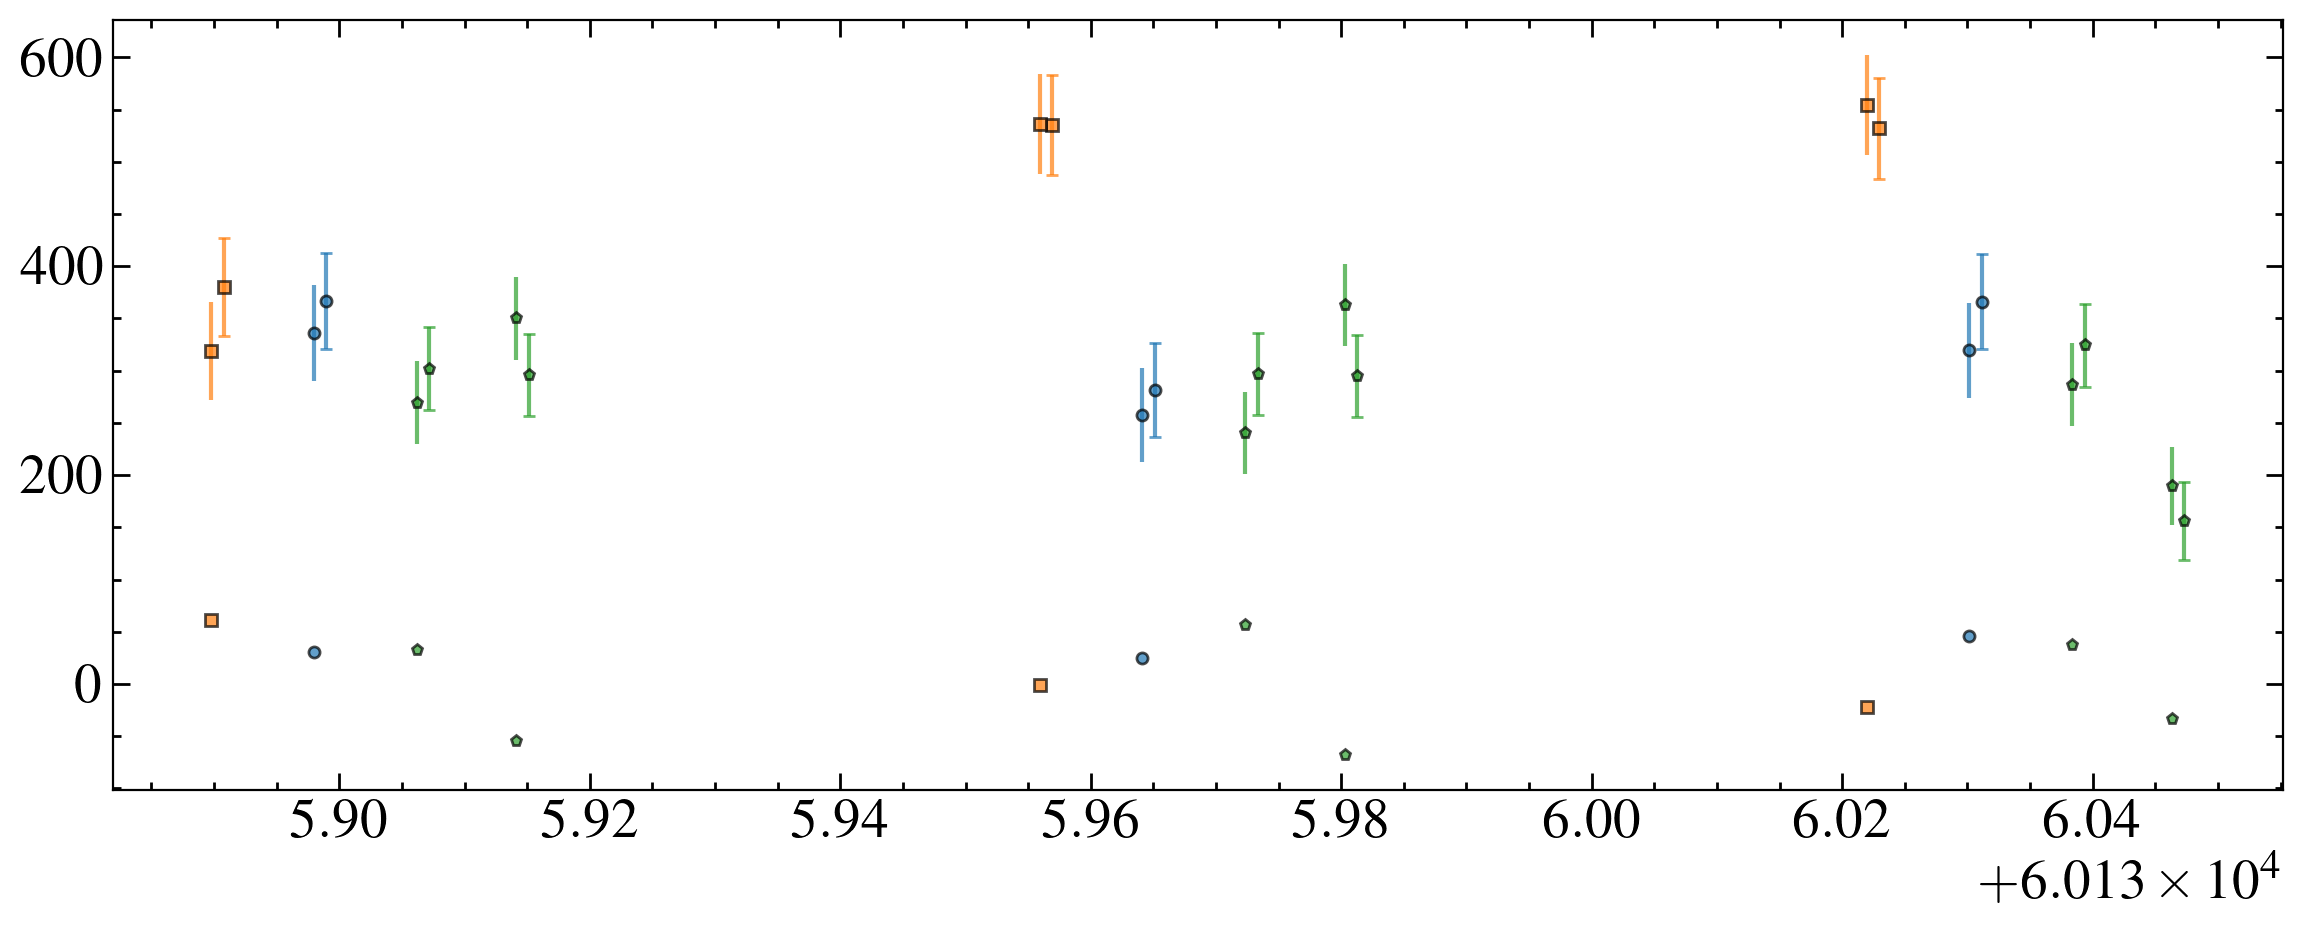

In [15]:
for i, phot in enumerate(wfc3):
    print(phot)
    fig, ax = plt.subplots()

    data = Table.read(phot)
    for row in data:
        if row['FILTER'] == 'F280N':
            c = 'C0'
            m = 'o'
        elif row['FILTER'] == 'F275W':
            c = 'C1'
            m ='s'
        elif row['FILTER'] == 'F225W':
            c = 'C2'
            m ='p'

   
        ax.errorbar(((row['EXPSTART']+row['EXPEND'])/2)+0.001, row['COUNTS']+row['BACKGROUND'], yerr=row['COUNTS_ERROR'], label = row['FILTER'], 
                    marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7, capsize=2)
        ax.errorbar((row['EXPSTART']+row['EXPEND'])/2, row['COUNTS'], yerr=row['COUNTS_ERROR'], label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)
        ax.errorbar((row['EXPSTART']+row['EXPEND'])/2, row['BACKGROUND'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)


            



fitted orbit = 94.72983525947083 min
real orbit = 94.9917376076 min
difference =  -0.27647292683641067 %


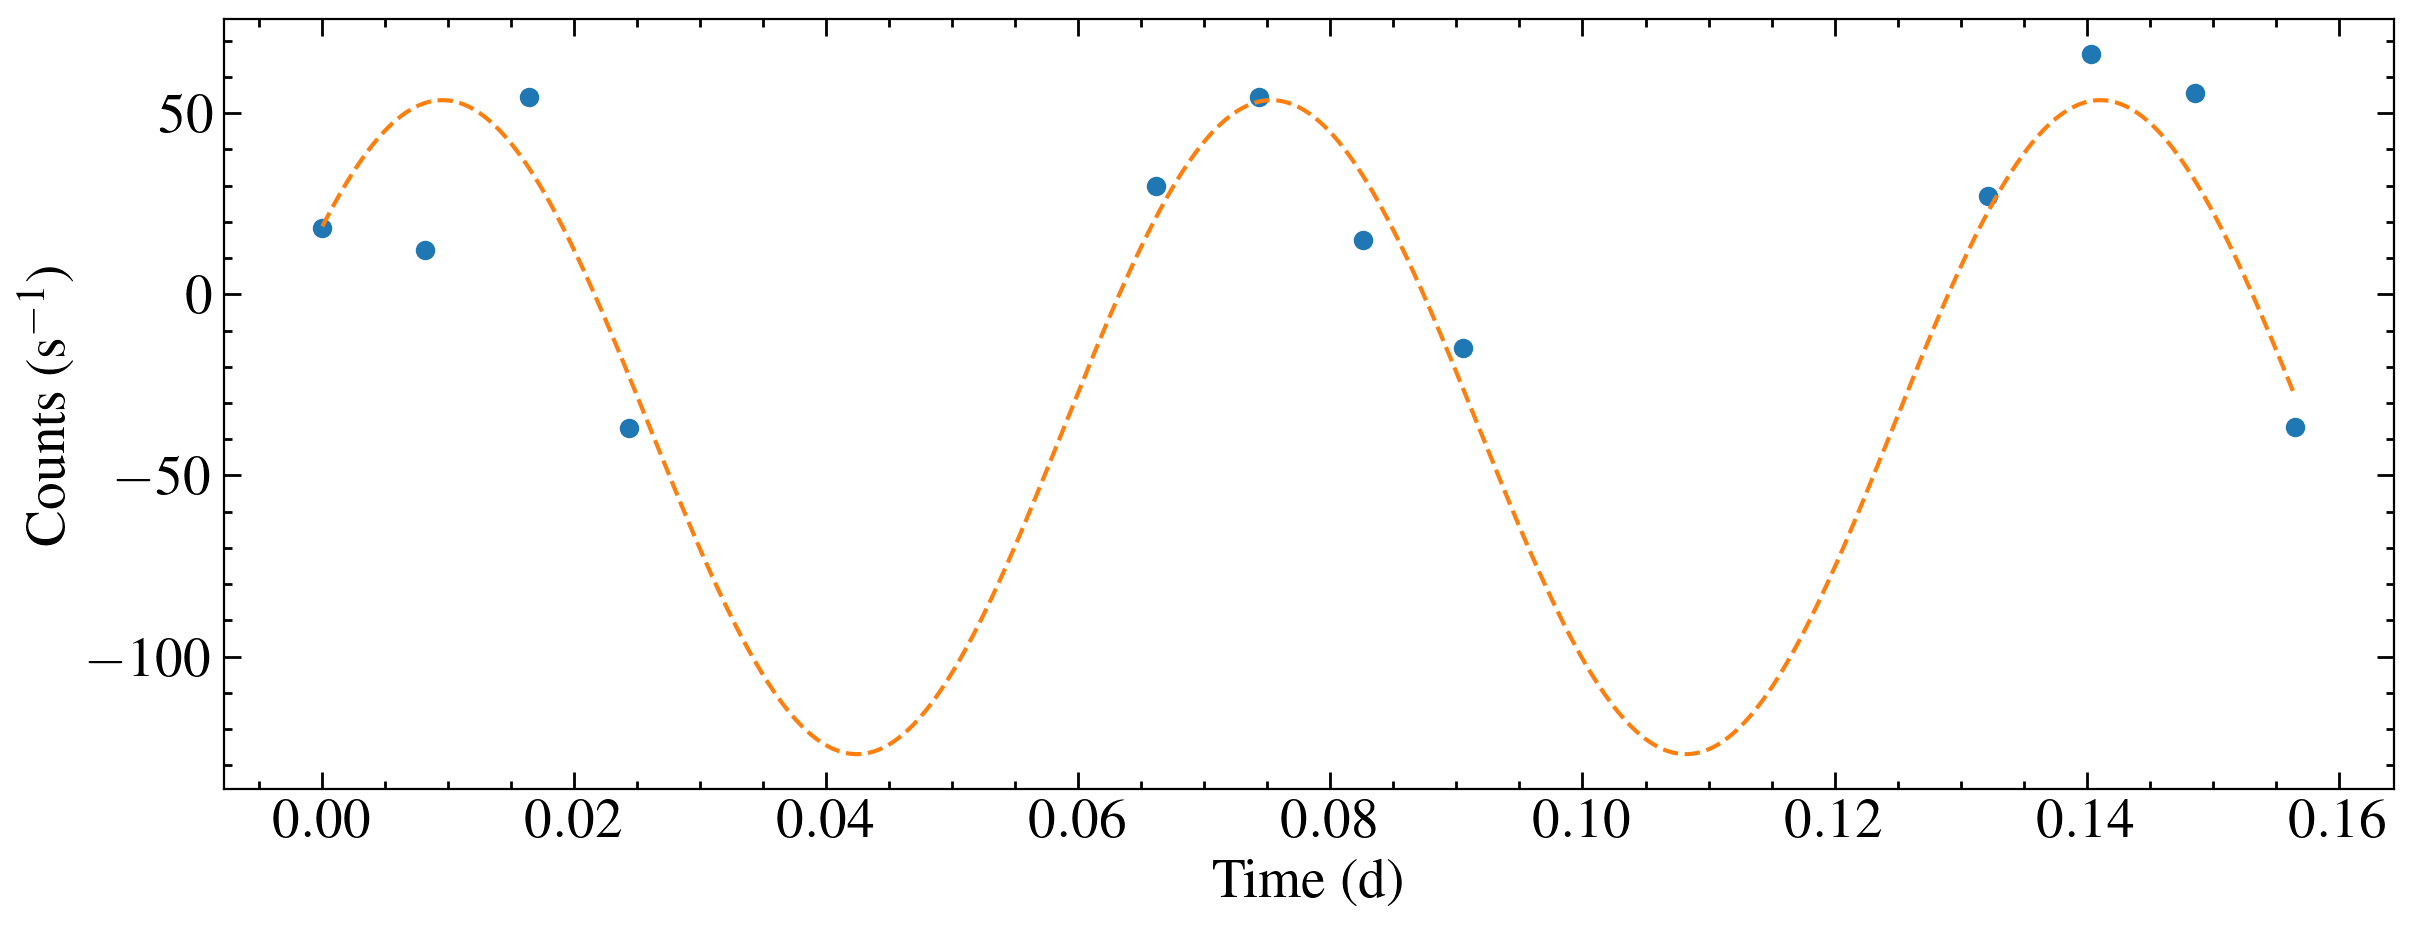

fitted orbit = 94.83007020360374 min
real orbit = 94.9917376076 min
difference =  -0.17048116029984559 %


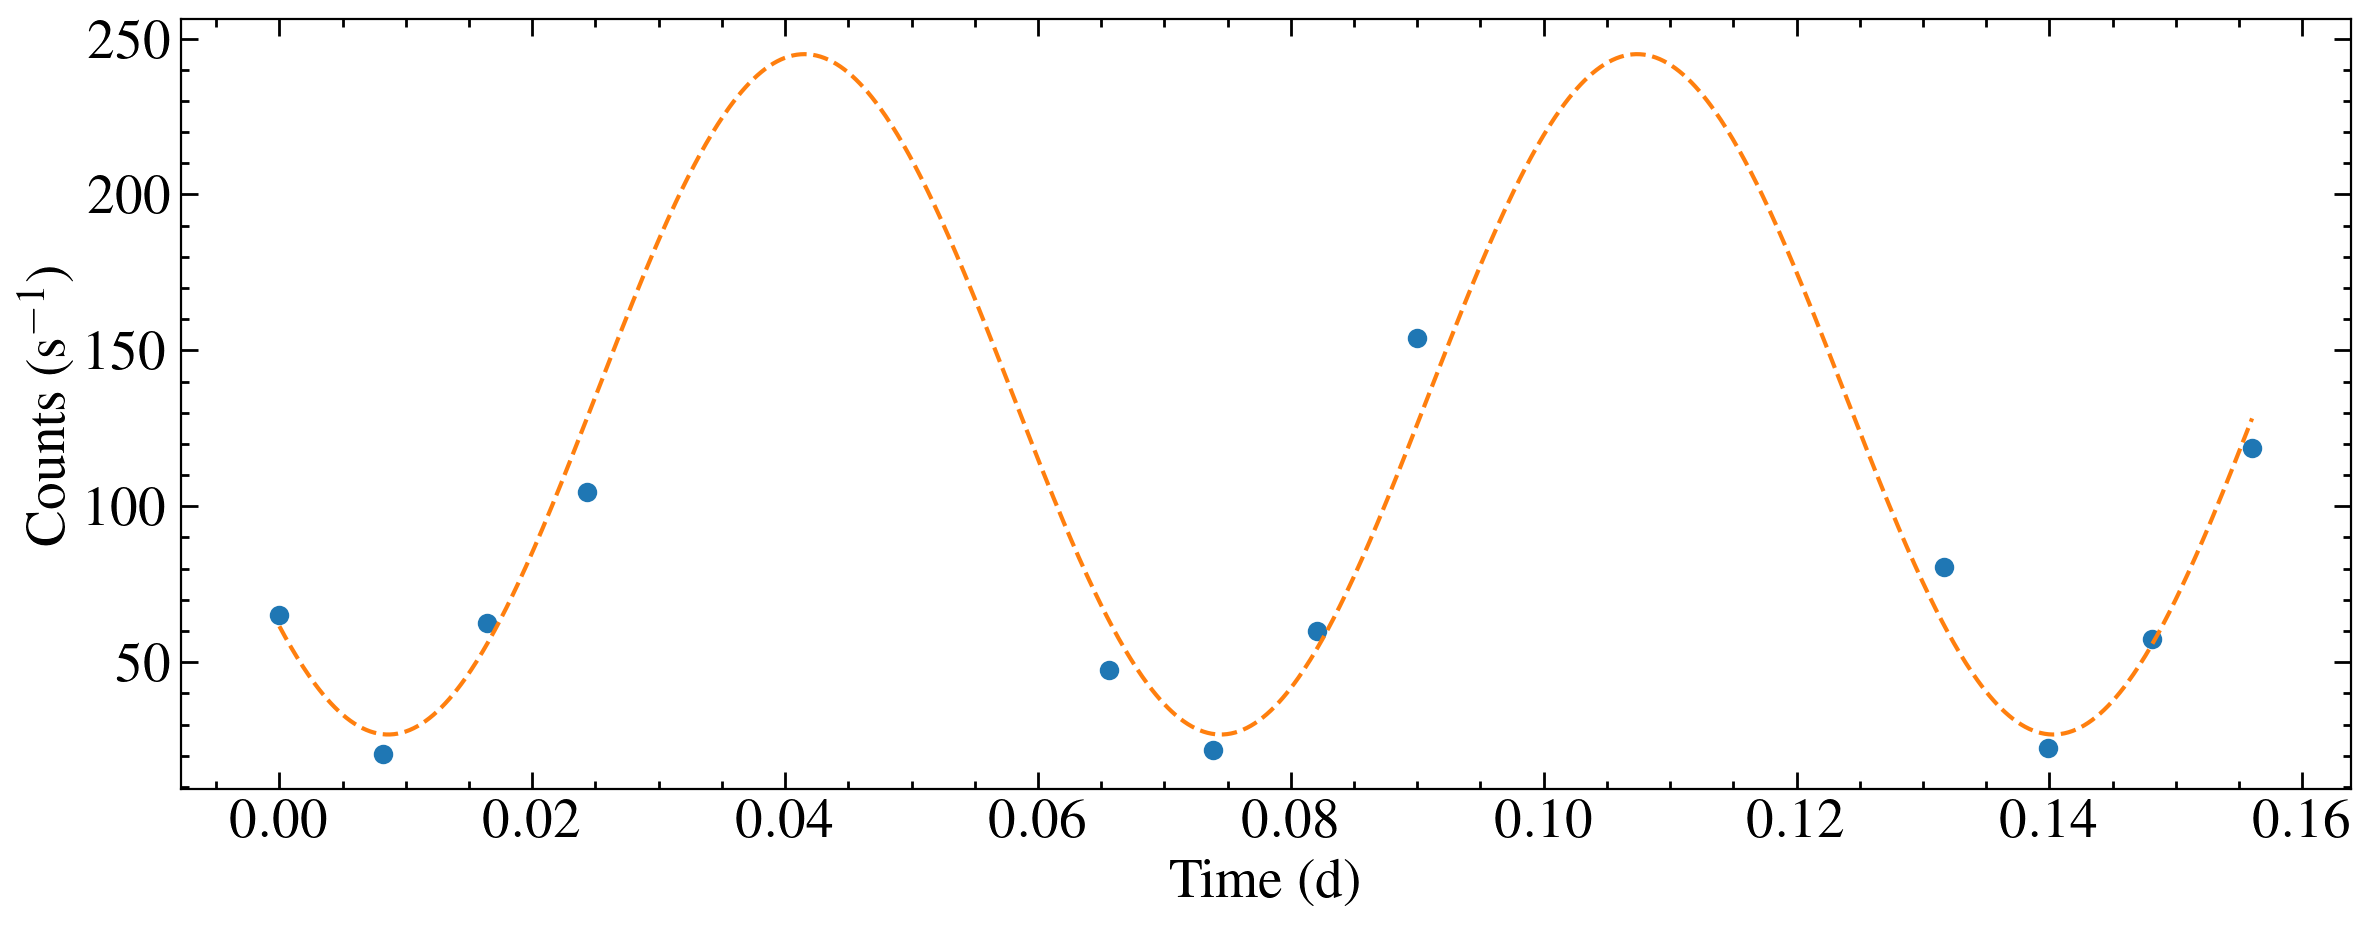

fitted orbit = 97.98040869634569 min
real orbit = 94.9917376076 min
difference =  3.050274160427294 %


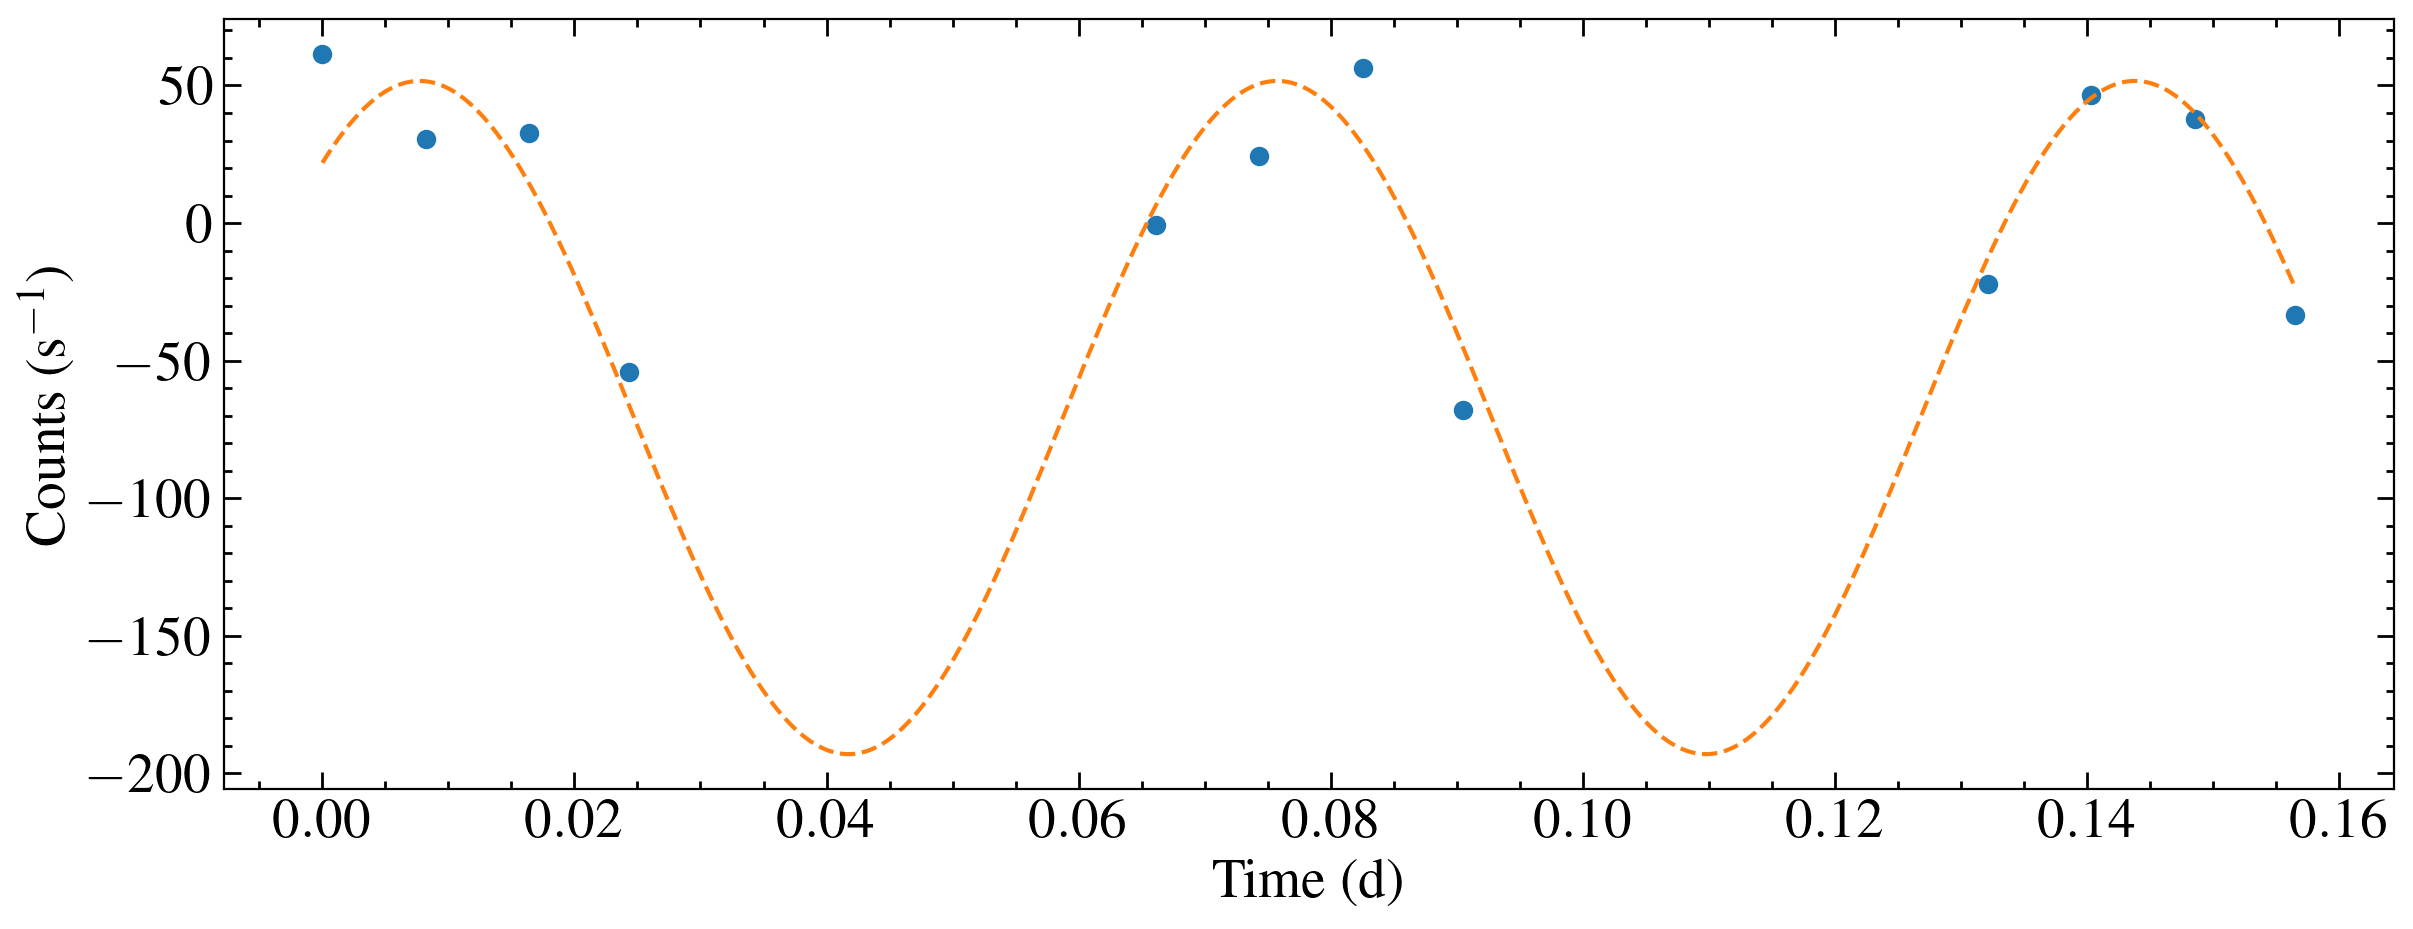

In [16]:


for i, phot in enumerate(wfc3):
#     print(phot)
    times = []
    bkg = []
    fig, ax = plt.subplots()

    data = Table.read(phot)
    for row in data:
        if row['FILTER'] == 'F280N':
            c = 'C0'
            m = 'o'
        elif row['FILTER'] == 'F275W':
            c = 'C1'
            m ='s'
        elif row['FILTER'] == 'F225W':
            c = 'C2'
            m ='p'

   
#         ax.errorbar(((row['EXPSTART']+row['EXPEND'])/2)+0.001, row['COUNTS']+row['BACKGROUND'], yerr=row['COUNTS_ERROR'], label = row['FILTER'], 
#                     marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7, capsize=2)
#         ax.errorbar((row['EXPSTART']+row['EXPEND'])/2, row['COUNTS'], yerr=row['COUNTS_ERROR'], label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)
#         ax.errorbar((row['EXPSTART']+row['EXPEND'])/2, row['BACKGROUND'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)
        times.append((row['EXPSTART']+row['EXPEND'])/2)
        bkg.append(row['BACKGROUND'][0])
    

    times = np.array(times) - min(times)

    plt.scatter(times, bkg)


    orb = ((90*u.min).to(u.d)).value
    mod = models.Const1D(100) + models.Sine1D(50, 1/orb)

    modfit = fitter(mod, times, bkg, maxiter=10000)

    timefit = np.linspace(min(times), max(times), 1000)
    plt.plot(timefit, modfit(timefit), ls='--', c='C1')
    # print((((1/modfit[1].frequency)*u.d).to(u.minute)))

    # print(modfit)

    hsthorb = 2.849752128228E+03 #from spt header
    # print(((hsthorb*2)*u.s).to(u.minute))

    myorb = ((1/modfit[1].frequency)*u.d).to(u.minute).value
    realorb = ((hsthorb*2)*u.s).to(u.minute).value
    ax.set_ylabel('Counts (s$^{-1}$)')
    ax.set_xlabel('Time (d)')

    print('fitted orbit =', myorb,'min')
    print('real orbit =', realorb, 'min')
    print('difference = ',((myorb-realorb)/myorb)*100, '%')
    plt.show()

How does the flux calibration change over time? Not at all.

In [17]:
f280n_phot = []
f280n_t  = []
f275w_phot = []
f275w_t  = []
f225w_phot = []
f225w_t  = []

for i in (1, 2, 3):
    flcs = glob.glob('/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch{}/wfc3/*flc.fits'.format(i))
    for flc in flcs:
        hdr = fits.getheader(flc,0)
        hdr1 = fits.getheader(flc,1)
        if hdr['FILTER'] == 'F280N':
            f280n_phot.append(hdr['PHOTFLAM'])
            f280n_t.append(hdr['EXPSTART'])
        
        if hdr['FILTER'] == 'F225W':
            f225w_phot.append(hdr['PHOTFLAM'])
            f225w_t.append(hdr['EXPSTART'])
        if hdr['FILTER'] == 'F275W':
            f275w_phot.append(hdr['PHOTFLAM'])
            f275w_t.append(hdr['EXPSTART'])
            
# plt.plot(f280n_t, f280n_phot)
# plt.show()
# plt.plot(f225w_t, f225w_phot)
# plt.show()

# plt.plot(f275w_t, f275w_phot)

print(min(f280n_phot)/max(f280n_phot))
print(min(f225w_phot)/max(f225w_phot))
print(min(f275w_phot)/max(f275w_phot))

0.9999235189049825
0.9999122502140647
0.9999252077260541


In [18]:
f280n_phot

[5.9173497e-17,
 5.9173517e-17,
 5.917353e-17,
 5.9175727e-17,
 5.9175753e-17,
 5.917574e-17,
 5.9177997e-17,
 5.917801e-17,
 5.9178023e-17]

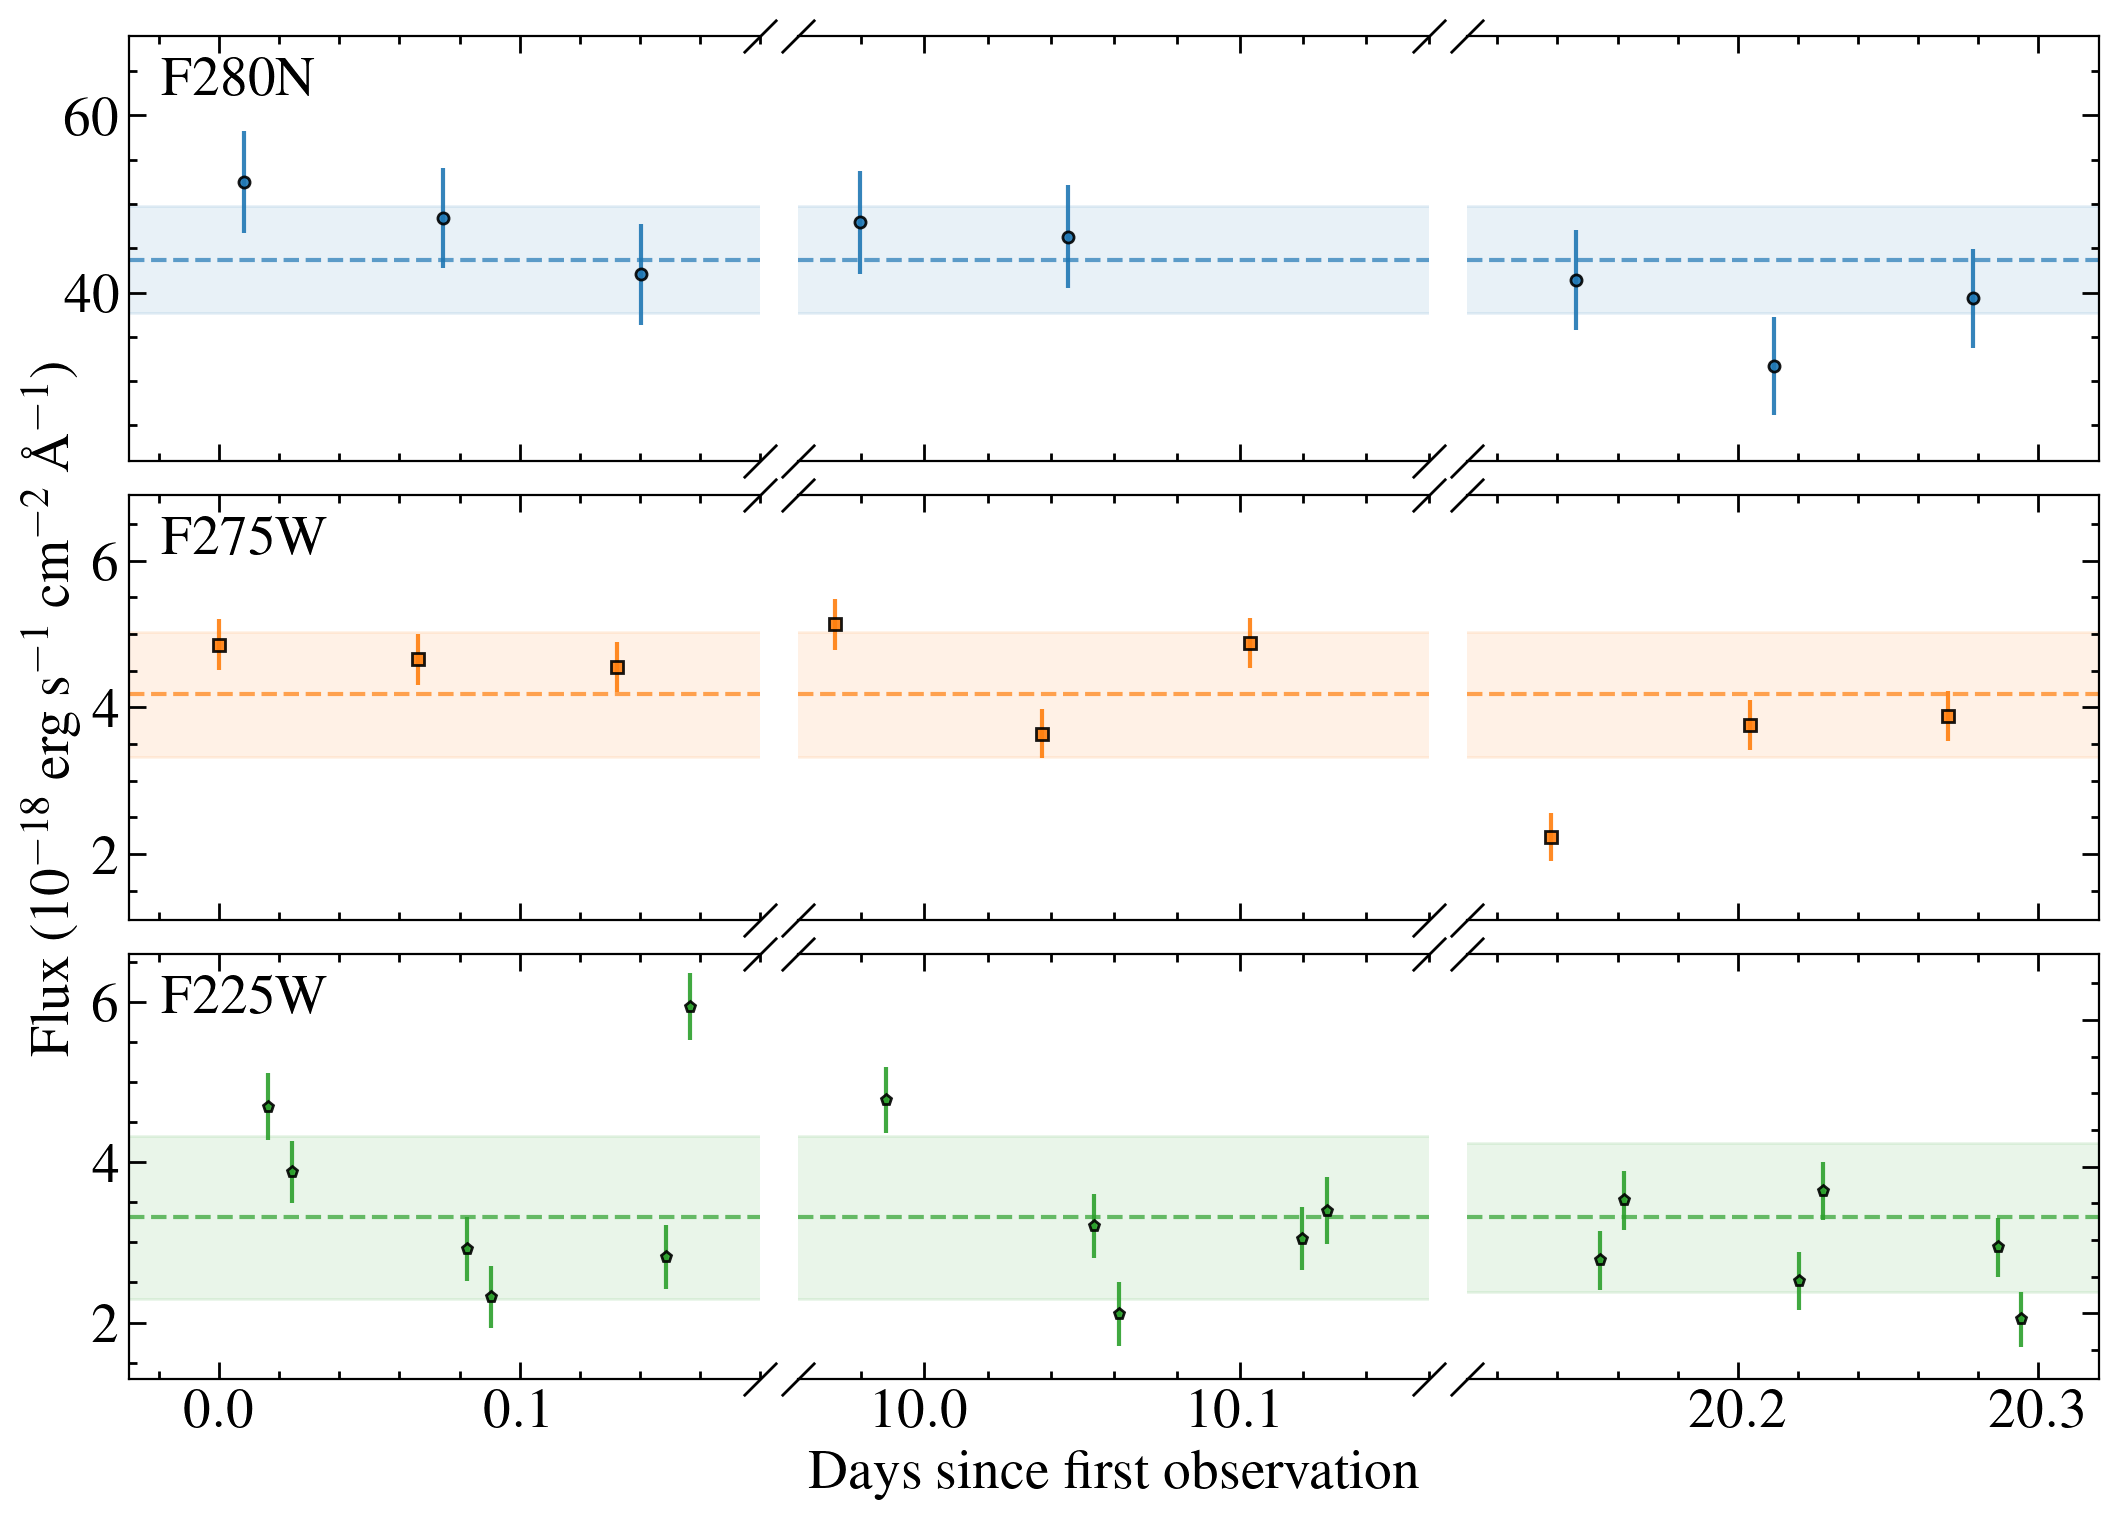

In [20]:
# fig, ax = plt.subplots(figsize=(6, 6))
# scale = 1e18

# #2023-06-20, 2023-06-30, 2023-07-10 
# days = [0, 10, 20]

f280n = []
f275w = []
f225w= []

# # cols = [0, 1, 2]



# fig.tight_layout()
# fig.savefig('plots/wfc3_all_visits.pdf')

fig, ax= plt.subplots(ncols=3, nrows=3, figsize=(11, 8))#, sharey=True)

# plot the same data on both axes
# ax1.plot(pts)
# ax2.plot(pts)

ax[0, 0].set_xlim(-0.03, 0.18) 
ax[0, 1].set_xlim(9.96, 10.16)  
ax[0, 2].set_xlim(20.11, 20.32)  
ax[1, 0].set_xlim(-0.03, 0.18) 
ax[1, 1].set_xlim(9.96, 10.16)  
ax[1, 2].set_xlim(20.11, 20.32)  
ax[2, 0].set_xlim(-0.03, 0.18) 
ax[2, 1].set_xlim(9.96, 10.16)  
ax[2, 2].set_xlim(20.11, 20.32)  


ax[0, 0].set_ylim(21, 69)
ax[0, 1].set_ylim(21, 69)
ax[0, 2].set_ylim(21, 69)
ax[1, 0].set_ylim(1.1, 6.9)
ax[1, 1].set_ylim(1.1, 6.9)
ax[1, 2].set_ylim(1.1, 6.9)
ax[1, 0].set_ylim(1.1, 6.9)
ax[1, 1].set_ylim(1.1, 6.9)
ax[2, 2].set_ylim(1.1, 6.9)

# # hide the spines between ax and ax2
ax[0,0].spines.right.set_visible(False)
ax[1,0].spines.right.set_visible(False)
ax[2,0].spines.right.set_visible(False)
ax[0,0].yaxis.tick_left()
ax[1,0].yaxis.tick_left()
ax[2,0].yaxis.tick_left()

ax[0,1].spines.right.set_visible(False)
ax[0,1].spines.left.set_visible(False)
ax[1,1].spines.right.set_visible(False)
ax[1,1].spines.left.set_visible(False)
ax[2,1].spines.right.set_visible(False)
ax[2,1].spines.left.set_visible(False)
ax[0,1].tick_params(right = False, left=False, which='both')
ax[1,1].tick_params(right = False, left=False, which='both')
ax[2,1].tick_params(right = False, left=False, which='both')
ax[0, 1].yaxis.set_tick_params(labelleft=False)
ax[1, 1].yaxis.set_tick_params(labelleft=False)
ax[2, 1].yaxis.set_tick_params(labelleft=False)


ax[0,2].spines.left.set_visible(False)
ax[0,2].yaxis.tick_right()
ax[1,2].spines.left.set_visible(False)
ax[1,2].yaxis.tick_right()
ax[2,2].spines.left.set_visible(False)
ax[2,2].yaxis.tick_right()
ax[0, 2].yaxis.set_tick_params(labelright=False)
ax[1, 2].yaxis.set_tick_params(labelright=False)
ax[2, 2].yaxis.set_tick_params(labelright=False)


ax[0, 0].xaxis.set_tick_params(labelbottom=False)
ax[0, 1].xaxis.set_tick_params(labelbottom=False)
ax[0, 2].xaxis.set_tick_params(labelbottom=False)
ax[1, 0].xaxis.set_tick_params(labelbottom=False)
ax[1, 1].xaxis.set_tick_params(labelbottom=False)
ax[1, 2].xaxis.set_tick_params(labelbottom=False)



# # Now, let's turn towards the cut-out slanted lines.
# # We create line objects in axes coordinates, in which (0,0), (0,1),
# # (1,0), and (1,1) are the four corners of the axes.
# # The slanted lines themselves are markers at those locations, such that the
# # lines keep their angle and position, independent of the axes size or scale
# # Finally, we need to disable clipping.

d = 1.  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0,0].plot([1, 1], [0, 1], transform=ax[0,0].transAxes, **kwargs)
ax[0,1].plot([0, 1], [1, 1], transform=ax[0,1].transAxes, **kwargs)
ax[0,1].plot([0, 1], [0, 0], transform=ax[0, 1].transAxes, **kwargs)
ax[0,2].plot([0, 0], [1, 0], transform=ax[0,2].transAxes, **kwargs)

ax[1,0].plot([1, 1], [0, 1], transform=ax[1,0].transAxes, **kwargs)
ax[1,1].plot([0, 1], [1, 1], transform=ax[1,1].transAxes, **kwargs)
ax[1,1].plot([0, 1], [0, 0], transform=ax[1, 1].transAxes, **kwargs)
ax[1,2].plot([0, 0], [1, 0], transform=ax[1,2].transAxes, **kwargs)

ax[2,0].plot([1, 1], [0, 1], transform=ax[2,0].transAxes, **kwargs)
ax[2,1].plot([0, 1], [1, 1], transform=ax[2,1].transAxes, **kwargs)
ax[2,1].plot([0, 1], [0, 0], transform=ax[2, 1].transAxes, **kwargs)
ax[2,2].plot([0, 0], [1, 0], transform=ax[2,2].transAxes, **kwargs)

# crs = ['if3i01i2q', 'if3i01i4q', 'if3i03z2q', 'if3i03zcq']
crs = ['if3i03z2q', 'if3i03zcq']


for i, phot in enumerate(wfc3):
    data = Table.read(phot)
#     data = data[mask]
    for row in data:
        if row['ROOTNAME'] not in crs:
            if row['FILTER'] == 'F280N':
                c = 'C0'
                m = 'o'
                f280n.append(row['FLUX'])
                r = 0
            elif row['FILTER'] == 'F275W':
                c = 'C1'
                m ='s'
                f275w.append(row['FLUX'])
                r = 1
            elif row['FILTER'] == 'F225W':
                c = 'C2'
                m ='p'
                f225w.append(row['FLUX'])
                r = 2
            ax[r, 0].errorbar(row['EXPSTART']-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
            ax[r, 1].errorbar(row['EXPSTART']-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
            ax[r, 2].errorbar(row['EXPSTART']-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)



#             if row['FILTER'] == 'F280N':
            

            
#             else:
#                 ax1.errorbar(row['EXPSTART']-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
#                 ax2.errorbar(row['EXPSTART']-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
#                 ax3.errorbar(row['EXPSTART']-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)

# x = np.arange(-5, 30)
ax[0, 0].axhline(np.mean(f280n)*scale, ls ='--', alpha=0.7, c='C0')
ax[0,0].fill_between(x, (np.mean(f280n)-np.std(f280n))*scale, (np.mean(f280n)+np.std(f280n))*scale, color='C0', alpha=0.1)
ax[0, 1].axhline(np.mean(f280n)*scale, ls ='--', alpha=0.7, c='C0')
ax[0,1].fill_between(x, (np.mean(f280n)-np.std(f280n))*scale, (np.mean(f280n)+np.std(f280n))*scale, color='C0', alpha=0.1)
ax[0, 2].axhline(np.mean(f280n)*scale, ls ='--', alpha=0.7, c='C0')
ax[0,2].fill_between(x, (np.mean(f280n)-np.std(f280n))*scale, (np.mean(f280n)+np.std(f280n))*scale, color='C0', alpha=0.1)



ax[1, 0].axhline(np.mean(f275w)*scale, ls ='--', alpha=0.7, c='C1')
ax[1, 0].fill_between(x, (np.mean(f275w)-np.std(f275w))*scale, (np.mean(f275w)+np.std(f275w))*scale, color='C1', alpha=0.1)
ax[1, 1].axhline(np.mean(f275w)*scale, ls ='--', alpha=0.7, c='C1')
ax[1, 1].fill_between(x, (np.mean(f275w)-np.std(f275w))*scale, (np.mean(f275w)+np.std(f275w))*scale, color='C1', alpha=0.1)
ax[1, 2].axhline(np.mean(f275w)*scale, ls ='--', alpha=0.7, c='C1')
ax[1, 2].fill_between(x, (np.mean(f275w)-np.std(f275w))*scale, (np.mean(f275w)+np.std(f275w))*scale, color='C1', alpha=0.1)

ax[2, 0].axhline(np.mean(f225w)*scale, ls ='--', alpha=0.7, c='C2')    
ax[2, 0].fill_between(x, (np.mean(f225w)-np.std(f225w))*scale, (np.mean(f225w)+np.std(f225w))*scale, color='C2', alpha=0.1)
ax[2, 1].axhline(np.mean(f225w)*scale, ls ='--', alpha=0.7, c='C2')    
ax[2, 1].fill_between(x, (np.mean(f225w)-np.std(f225w))*scale, (np.mean(f225w)+np.std(f225w))*scale, color='C2', alpha=0.1)
ax[2, 2].axhline(np.mean(f225w)*scale, ls ='--', alpha=0.7, c='C2')    
ax[2, 2].fill_between(x, (np.mean(f225w)-np.std(f225w))*scale, (np.mean(f225w)+np.std(f225w))*scale, color='C2', alpha=0.1)


    
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# ax3.legend(by_label.values(), by_label.keys(), frameon=True, loc=1) 

ax[1, 0].set_ylabel('Flux (10$^{-18}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax[2, 1].set_xlabel('Days since first observation')
ax[0,0].annotate('F280N', (0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
ax[1,0].annotate('F275W', (0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
ax[2,0].annotate('F225W', (0.05, 0.95), xycoords='axes fraction', ha='left', va='top')


fig.tight_layout()
fig.subplots_adjust(wspace=0.06, hspace=0.08)  # adjust space between axes



# plt.show()

plt.savefig('plots/t1_seperate_lcs.pdf')


In [29]:
f280n = []
f275w = []
f225w= []
f280n_e = []
f275w_e = []
f225w_e= []


for i, phot in enumerate(wfc3):
    data = Table.read(phot)
    for row in data:
        if row['ROOTNAME'] not in crs:
            if row['FILTER'] == 'F280N':
                f280n.append(row['FLUX'])
                f280n_e.append(row['ERROR'])
            elif row['FILTER'] == 'F275W':
                f275w.append(row['FLUX'])
                f275w_e.append(row['ERROR'])
            elif row['FILTER'] == 'F225W':
                f225w.append(row['FLUX'])                
                f225w_e.append(row['ERROR'])

f280n ,f275w, f225w,f280n_e, f275w_e, f225w_e = np.array(f280n) ,np.array(f275w), np.array(f225w),np.array(f280n_e), np.array(f275w_e), np.array(f225w_e) 
    
print('F280N')
print(f280n/f280n_e)
print(np.mean(f280n/f280n_e), np.median(f280n/f280n_e), np.std(f280n/f280n_e))

print('F275W')
print(f275w/f275w_e)
print(np.mean(f275w/f275w_e), np.median(f275w/f275w_e), np.std(f275w/f275w_e))

print('F225W')
print(f225w/f225w_e)
print(np.mean(f225w/f225w_e), np.median(f225w/f225w_e), np.std(f225w/f225w_e))

F280N
[9.14418742 8.55766444 7.3628469  8.24466389 7.94380552 7.31336112
 5.723755   7.03972321]
7.666250937749035 7.653326206601205 0.9857056534974088
F275W
[14.0312499  13.31845758 13.15677848 14.76643432 10.90572431 14.29642339
  6.80489949 11.22547848 11.52817312]
12.225957674178588 13.15677847706173 2.3256698720707645
F2825W
[11.24585223 10.05085172  7.31680938  5.99192474  7.0766953  14.23988571
 11.51194646  7.99909103  5.27685515  7.73512235  8.18557964  6.75943478
  8.90299388  6.14533396  9.28452786  7.22908732  5.04263944]
8.234978290783536 7.735122350873731 2.360571356819626


In [44]:
# 5.93668747e-18 4.16905556e-19
print(f225w)
print(f225w_e)
mask = (f225w < 5.5e-18)

print(np.mean(f225w))
print(np.mean(f225w[mask]))
print(np.std(f225w))
print(np.std(f225w[mask]))

print((5.93668747e-18-np.mean(f225w[mask]))/np.std(f225w[mask]))

print((5.93668747e-18-2.82143790e-18)/4.16905556e-19)

print(f275w)

[4.69310477e-18 3.88067809e-18 2.92268963e-18 2.31512167e-18
 2.82143790e-18 5.93668747e-18 4.77566797e-18 3.20285476e-18
 2.11109319e-18 3.04757464e-18 3.39642084e-18 2.72078217e-18
 3.53762644e-18 2.43270975e-18 3.66629328e-18 2.89837741e-18
 1.91557167e-18]
[4.17318730e-19 3.86104402e-19 3.99448650e-19 3.86373622e-19
 3.98694275e-19 4.16905556e-19 4.14844526e-19 4.00402339e-19
 4.00066543e-19 3.93991783e-19 4.14927347e-19 4.02516225e-19
 3.97352451e-19 3.95862904e-19 3.94882038e-19 4.00932688e-19
 3.79874804e-19]
3.3102759793837306e-18
3.146125261118101e-18
1.0174777678184337e-18
8.011816459355579e-19
3.4830580843165673
7.47231483285869
[4.85650453e-18 4.65488424e-18 4.54961383e-18 5.13228303e-18
 3.64262342e-18 4.88106028e-18 2.23367932e-18 3.75975525e-18
 3.88544057e-18]


In [45]:
3.8/2.2

1.727272727272727

4.7625748853059357e-17 4.687123024201185e-18 3.702870943117048e-18 3.291278334269941e-18 2.0041570552963399e-19 1.7036965804715411e-19
4.709977014621346e-17 4.5316798905666145e-18 3.282795214017994e-18 4.114500703837729e-18 1.9679684412744362e-19 1.855241119922278e-19
3.742078227266277e-17 3.2761282890842853e-18 2.8488357373977445e-18 3.231238607826323e-18 1.9245466760523983e-19 1.643265608372743e-19


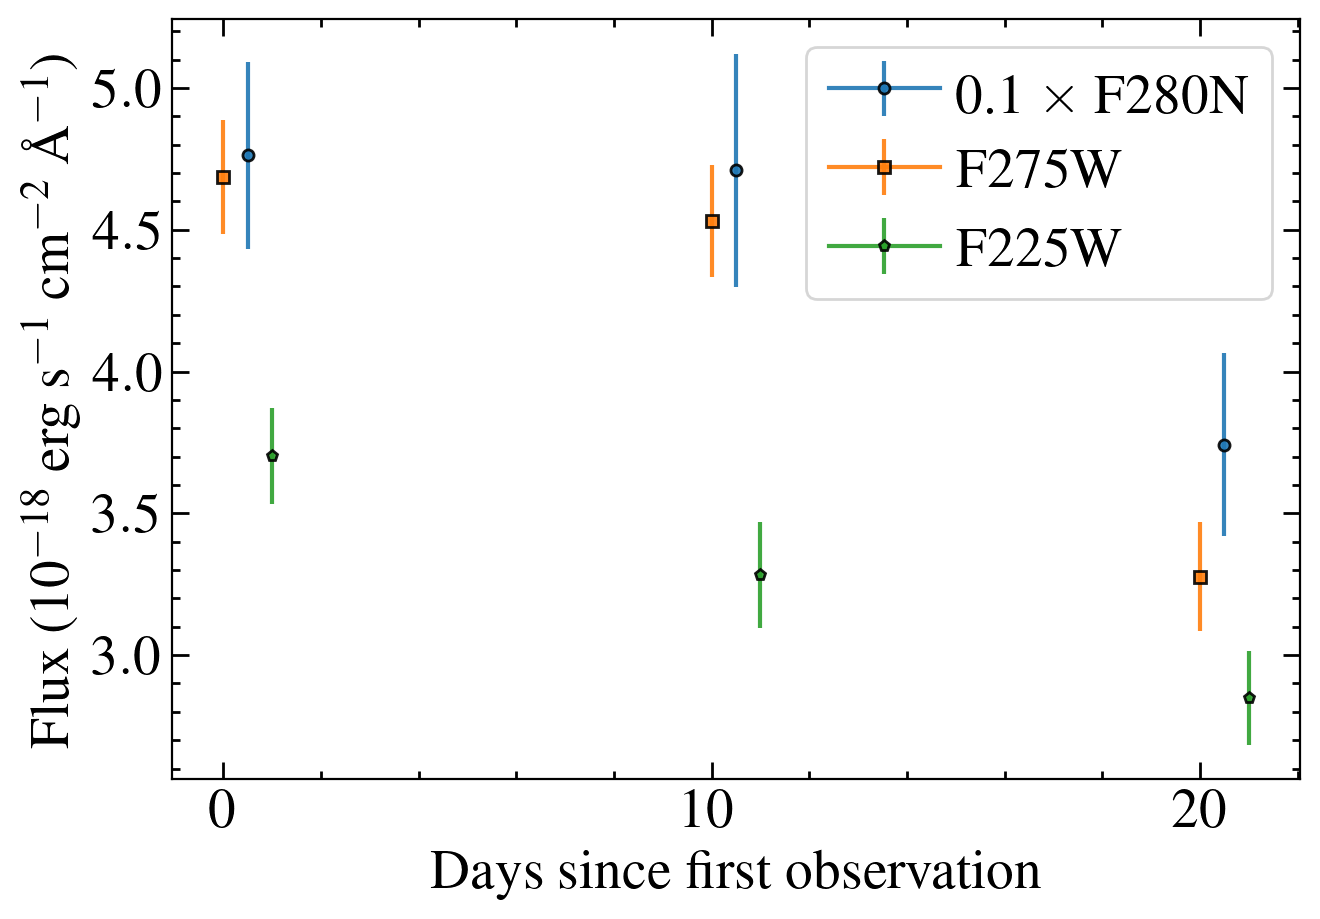

In [94]:
fig, ax = plt.subplots(figsize=(7, 5))
scale = 1e18

#2023-06-20, 2023-06-30, 2023-07-10 
days = [0, 10, 20]

# cols = [0, 1, 2]

for i, phot in enumerate(wfc3):
    data = Table.read(phot)
    
    f280n = []
    f275w = []
    f225w= []
    f280n_e = []
    f275w_e = []
    f225w_e= []
    for row in data:
        if row['ROOTNAME'] not in crs:
            if row['FILTER'] == 'F280N':
                c = 'C0'
                m = 'o'
                f280n.append(row['FLUX'])
                f280n_e.append(row['ERROR'])
            elif row['FILTER'] == 'F275W':
                c = 'C1'
                m ='s'
                f275w.append(row['FLUX'])
                f275w_e.append(row['ERROR'])
            elif row['FILTER'] == 'F225W':
                c = 'C2'
                m ='p'
                f225w.append(row['FLUX'])
                f225w_e.append(row['ERROR'])

    f280n ,f275w, f225w,f280n_e, f275w_e, f225w_e = np.array(f280n) ,np.array(f275w), np.array(f225w),np.array(f280n_e), np.array(f275w_e), np.array(f225w_e) 
    
    f280n_av = np.average(f280n, weights = 1/(f280n_e**2))
    f280n_ave = (1/(np.sum(1/(f280n_e**2))))**0.5
    ax.errorbar(days[i]+0.5, f280n_av*scale/10, yerr=f280n_ave*scale/10, marker='o', c='C0', label = r'0.1 $\times$ F280N',  markeredgecolor='k', markersize=4, alpha=0.9)
        
#     if i == 2:
#         f275w_av = np.average(f275w[1:], weights = 1/(f275w_e[1:]**2))
#         f275w_ave = (1/(np.sum(1/(f275w_e[1:]**2))))**0.5
    
#     else:
    f275w_av = np.average(f275w, weights = 1/(f275w_e**2))
    f275w_ave = (1/(np.sum(1/(f275w_e**2))))**0.5
    ax.errorbar(days[i], f275w_av*scale, yerr=f275w_ave*scale, marker='s', c='C1', label='F275W',  markeredgecolor='k', markersize=4, alpha=0.9)
    
    f225w_av = np.average(f225w, weights = 1/(f225w_e**2))
    f225w_e = np.full(len(f225w), f225w_e[0])
    f225w_ave = (1/(np.sum(1/(f225w_e**2))))**0.5
    ax.errorbar(days[i]+1, f225w_av*scale, yerr=f225w_ave*scale, marker='p', c='C2', label = 'F225W',  markeredgecolor='k', markersize=4, alpha=0.9)
    
    print(f280n_av ,f275w_av, f225w_av,f280n_ave, f275w_ave, f225w_ave)
    
#     print(f280n_av/f275w_av)
#     print(f280n_av/f225w_av)

            
        
            
#         if row['FILTER'] == 'F280N':
#             ax.errorbar(days[i], row['FLUX']*scale/10, yerr=row['ERROR']*scale/10, label = '0.1 x {}'.format(row['FILTER']), 
#                         marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)
#         else:
#             ax.errorbar(days[i], row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)




# ax.axhline(np.mean(f280n)*scale/10, ls ='--', alpha=0.5, c='C0')
# ax.axhline(np.mean(f275w)*scale, ls ='--', alpha=0.5, c='C1')
# ax.axhline(np.mean(f225w)*scale, ls ='--', alpha=0.5, c='C2')
        
# ax.set_yscale('log')
ax.set_ylabel('Flux (10$^{-18}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.set_xlabel('Days since first observation')
ax.set_xticks(days)

# ax.set_xlim(-4, 49)
# ax.set_ylim(2.1, 7.9)

    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), frameon=True, loc=1) 

fig.tight_layout()
fig.savefig('plots/wfc3_average_visits.pdf')

In [87]:
3.742078227266277e-17/4.7625748853059357e-17

0.7857258557365225

In [88]:
3.2761282890842853e-18/4.687123024201185e-18

0.6989635800401522

In [89]:
2.8488357373977445e-18/3.702870943117048e-18

0.7693586358155968